<h2>Notebook guide</h2>

<b>Part 1: </b>
<ul>
    <li><a href="#intro">Introduction</li>
    <li><a href="#imports">Imports</li>
    <li><a href="#eda">Performing EDA</li>
    <ul>
        <li><a href="#correlations">Correlations</li>
        <li><a href="#distributions">Qualification distributions</li>
        <li><a href="#local_authorities">Local Authorities ranked by health </li>
        <li><a href="#health_distributions">Health distributions</li>
        <li><a href="#mapping">Mapping Health</li>
    </ul>
    <li><a href="#notes before modelling">Final notes before modelling</li>
</ul>
    
<b>Part 2: </b>
    <ul>
    <li><a href="#modelling">Modelling</li>
    <ul>
        <li><a href="#linear regression">Linear Regression: Basic, Lasso, Ridge, ElasticNet</li>
        <li><a href="#investigating lasso">Investigating the Lasso Model</li>
        <ul>
            <li><a href="#feature importances">Notes on the Feature Importances</li>
            <li><a href="#plotting residuals">Plotting the residuals</li>
            <li><a href="#lasso notes">Notes</li>
        </ul>
        <li><a href="#other models">Testing other models</li>
        <ul>
            <li><a href="#knn">KNeighborsRegressor</li>
            <li><a href="#decision tree">DecisionTreeRegressor</li>
            <li><a href="#random forest">RandomForestRegressor</li>
            <li><a href="#bagging">BaggingRegressor</li>
        </ul>
        <li><a href="#bayesian">Bayesian Modelling</li>
        <ul>
            <li><a href="#set up">Setting up the model</li>
            <li><a href="#posteriors">Visualizing the posteriors</li>
            <li><a href="#scoring">Scoring</li>
        </ul>    
    </ul>
    <li><a href="#comparisons">Comparing results from Lasso and Bayesian Models</li>
</ul>



<a id="intro"></a>
#### Introduction 

Now that I have a clean dataset, I'll perform EDA before moving on to modelling. 

It is important to remember that each row of my data represents a 'middle layer super output area', or MSOA. The entries in each column indicate what percentage of the MSOA exhibit that column variable. 

Each MSOA contains clusters of adjacent postcodes, designed to have similar population size and to be as homogenous as possible. Urban / rural mixes are avoided. The minimum population is 5000 and the mean is 7200. A visual representation of how census geographies are related: 

<img src="./images/statistical_geographies.png" style="width:400px;height:500px;" >
Image source: UK Data Service


<a id="imports"></a>
#### Imports

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as mpatches

import seaborn as sns
from scipy import stats
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import shapefile as shp

import pydotplus
from ipywidgets import *
from IPython.display import display
from IPython.display import Image

sns.set(font_scale=1.2, style='dark', palette='deep')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from tqdm import tqdm_notebook

import warnings
warnings.simplefilter(action='ignore')

In [2]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
import cufflinks
import plotly.io as pio
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

In [3]:
data = pd.read_csv('datasets/clean_data/geo_census.csv')
data.head(2)

GeographyCode                                             coords  \
0     E02003113  [(368710.883, 173101.639), (368667.312, 173141...   
1     E02001245  [(393356.551, 398022.687), (393367.892, 398040...   

                        MSOA     LACode                     LA  Tot_people  \
0  South Gloucestershire 024  E06000025  South Gloucestershire     10167.0   
1               Tameside 017  E08000008               Tameside      7848.0   

   Tot_area_hect    Density      Male%    Female%  ...  Health_b  Health_vb  \
0       17027.36   0.597098  49.522966  50.477034  ...  2.862201   0.885217   
1         262.79  29.864150  49.490316  50.509684  ...  5.721203   1.745668   

      Qual_0     Qual_1     Qual_2    Qual_A     Qual_3     Qual_4  \
0  18.240807  12.821437  15.176640  4.073540  11.860130  34.318673   
1  27.859516  16.231609  18.193324  4.034172  13.257396  16.658757   

   Qual_Other  couple_living  
0    3.508772      67.665901  
1    3.765227      55.525348  

[2 rows x 25 columns]

<a id="eda"></a>
#### Performing EDA

In [4]:
data.describe()

Tot_people  Tot_area_hect      Density        Male%      Female%  \
count   7201.000000    7201.000000  7201.000000  7201.000000  7201.000000   
mean    7787.239550    2097.118988    32.180138    49.124439    50.875561   
std     1599.634138    5308.769125    34.312539     1.521838     1.521838   
min     2203.000000      29.420000     0.057270    44.228880    38.717617   
25%     6553.000000     173.050000     6.489764    48.276321    50.360183   
50%     7616.000000     318.230000    24.443206    48.941099    51.058901   
75%     8707.000000    1174.380000    44.183228    49.639817    51.723679   
max    16342.000000  111715.910000   247.209238    61.282383    55.771120   

       Household_living%  Communal_living%    Health_vg     Health_g  \
count        7201.000000       7201.000000  7201.000000  7201.000000   
mean           98.310303          1.689697    47.015762    34.065205   
std             3.603783          3.603783     5.180037     2.200104   
min            31.281361          0.000000    26.615503    23.038445   
25%            98.384387          0.274332    43.448390    32.812768   
50%            99.197578          0.802422    46.528275    34.315840   
75%            99.725668          1.615613    50.163011    35.598324   
max           100.000000         68.718639    67.918947    42.061782   

          Health_f     Health_b    Health_vb       Qual_0       Qual_1  \
count  7201.000000  7201.000000  7201.000000  7201.000000  7201.000000   
mean     13.283315     4.354423     1.281295    22.930142    13.409956   
std       2.615988     1.596633     0.536390     7.970171     3.099639   
min       3.597666     0.711041     0.227151     1.660255     1.848989   
25%      11.516342     3.200000     0.887330    17.275362    11.654850   
50%      13.323420     4.072605     1.186611    22.079589    13.807964   
75%      15.098104     5.269690     1.578888    27.970297    15.545697   
max      25.502406    12.142979     4.518026    50.667214    23.295355   

            Qual_2       Qual_A       Qual_3       Qual_4   Qual_Other  \
count  7201.000000  7201.000000  7201.000000  7201.000000  7201.000000   
mean     15.364010     3.644368    12.159409    26.942074     5.550042   
std       2.651568     1.469436     3.923456    11.318955     2.848378   
min       4.026543     0.190048     6.352796     4.841915     1.721440   
25%      14.446861     2.730168    10.606728    18.377353     3.864247   
50%      15.970193     3.747204    11.685347    25.518630     4.511430   
75%      17.064405     4.604746    12.676776    33.580247     5.975197   
max      23.759993    10.994575    65.436380    71.373775    24.739389   

       couple_living  
count    7201.000000  
mean       58.044811  
std         9.496252  
min         8.278146  
25%        52.596401  
50%        59.798150  
75%        65.512080  
max        77.419355

In [5]:
data.shape

(7201, 25)

<a id="correlations"></a>
##### Correlations

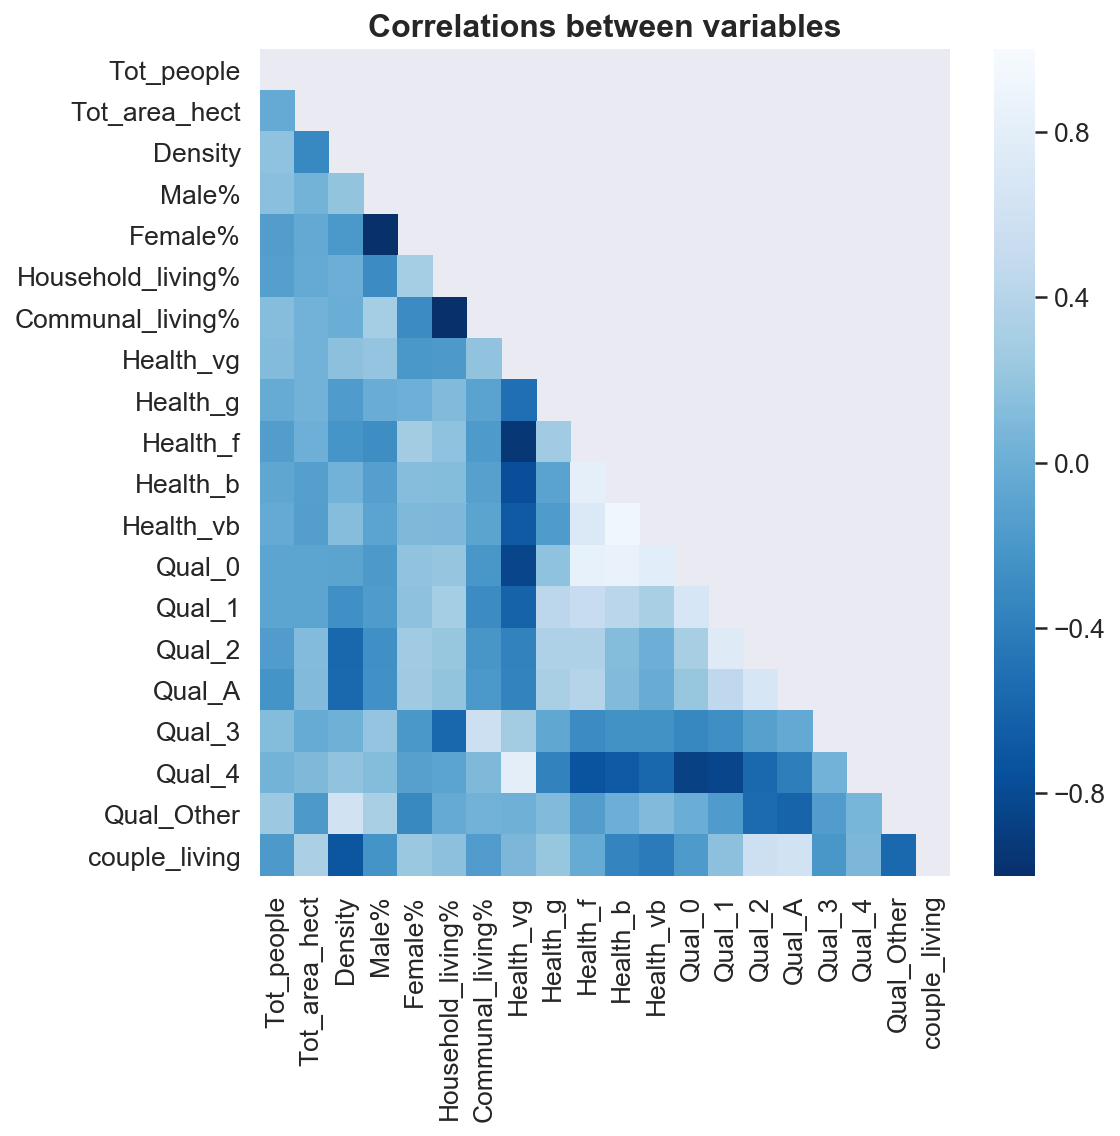

In [6]:
corr = data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(8,8))
ax = sns.heatmap(corr, mask=mask, cmap="Blues_r")

ax.set_title('Correlations between variables', fontsize=16, fontweight='bold')
plt.tight_layout()

#plt.savefig('images/agg_heatmap.png', dpi=200)
plt.draw()

<b>Notes:</b> This shows me that some of the variables are perfectly correlated (indicated with dark blue squares), and that's because they are designed to add up to 100%. In these two cases (household / communal living, and male / female), I'll drop one of the predictor columns as the information can be inferred from the other. 


<a id="distributions"></a>
##### Qualification distributions

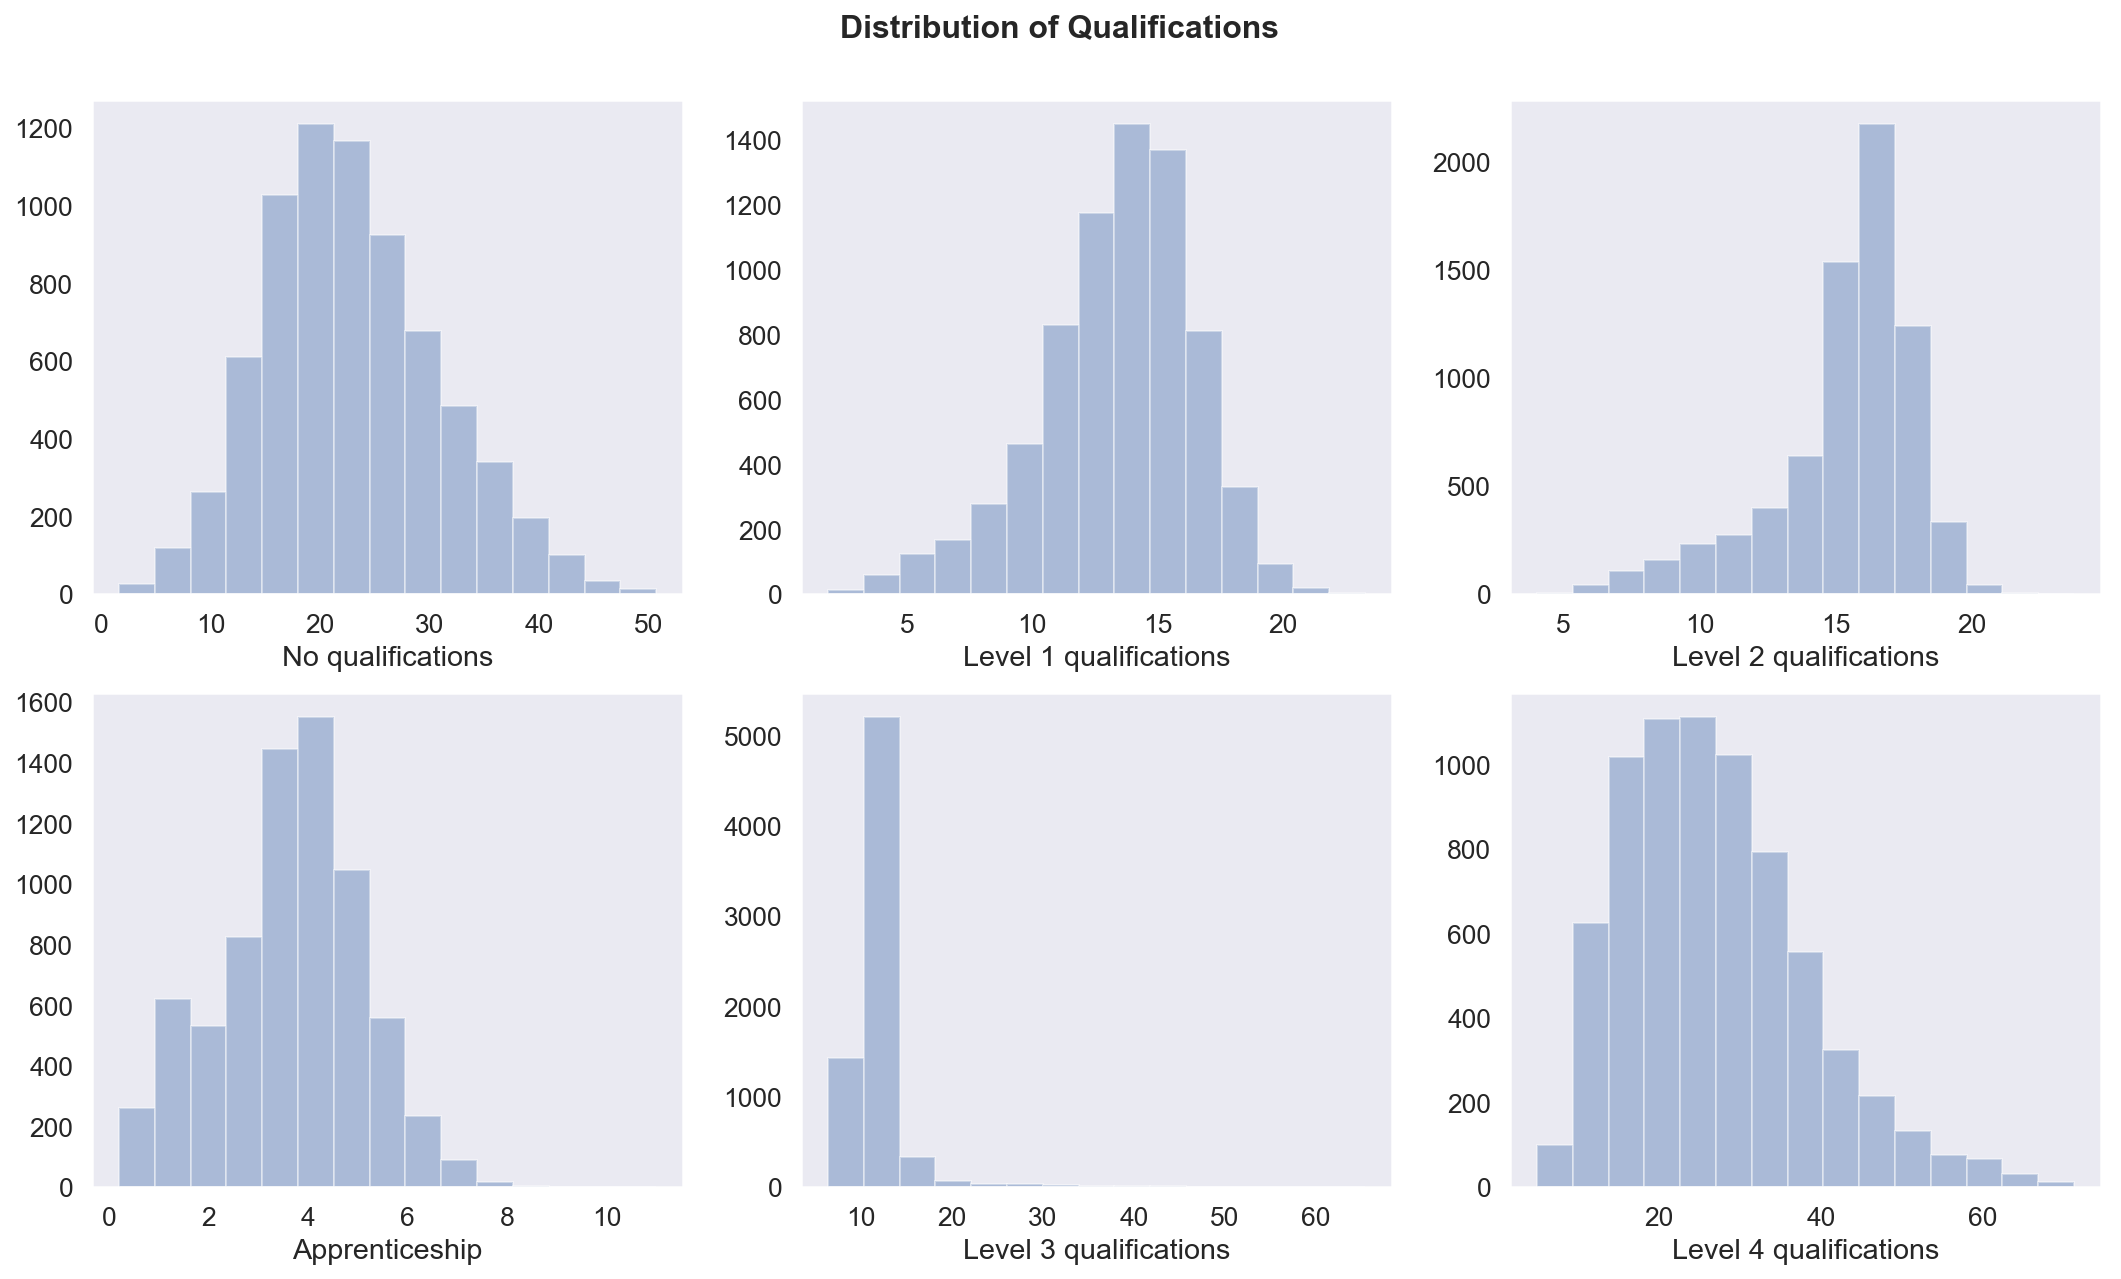

In [140]:
#Plotting the distribution of the Qualification variables

fig, ax = plt.subplots(nrows=2, ncols = 3, figsize = (18,10))

sns.distplot(data.Qual_0, bins=15, kde=False, ax=ax[0,0], axlabel='No qualifications')
sns.distplot(data.Qual_1, bins=15, kde=False, ax=ax[0,1], axlabel='Level 1 qualifications')
sns.distplot(data.Qual_2, bins=15, kde=False, ax=ax[0,2], axlabel='Level 2 qualifications')

sns.distplot(data.Qual_A, bins=15, kde=False, ax=ax[1,0], axlabel='Apprenticeship')
sns.distplot(data.Qual_3, bins=15, kde=False, ax=ax[1,1], axlabel='Level 3 qualifications')
sns.distplot(data.Qual_4, bins=15, kde=False, ax=ax[1,2], axlabel='Level 4 qualifications')


fig.suptitle('Distribution of Qualifications ', fontsize=16, fontweight='bold', y=.94)

#plt.savefig('images/qual_distributions.png', dpi=200)
plt.show()

<b>Notes: </b>remember, each entry in the dataframe is an output area, and shows an aggregate value. For qualifications, it is showing the percentage of that area for which this qualification indicates their highest level of education. 
    
Level 1, 2, and 3 are 1-4 GCSEs, 5 GCSEs and 2 or more A-levels respectively. Level 4 indicates a bachelor degree or higher. 

Take note of the different axis scales as they can be quite misleading. By plotting all these distributions on one plot below with plotly the relative scales are easier to see. 

Level 3 qualifications have a strong positive skew, and this distribution is the most extreme of the qualifications. I'll isolate the MSOAS contributing to this positive skew below, as we may be able to link this to a particular drive in the schooling systems in those areas to get A levels. 

The x-axis for Apprenticeships remains low, with the distribution centered around approximately 4 percent. It will be interesting to see how the Apprenticeship Levy, introduced in 2017, changes this distribution in the next census. 

No qualifications and Level 4 qualifications (bachelor degree or higher) have a similar spread and centre between 20/30 percent. The counts (y-axis) are also on a comparable scale. 

In [15]:
# MSOAs (and corresponding Local Authorities) for which more than 50% of the population has highest qualifications
# of 2 or more A levels. These MSOAs are all in big cities - a more in depth study might be able to reseach this  
# further, I wonder if it is as simple as city schools having better resources for A-level students. 

data[data.Qual_3 > 50][['MSOA', 'LA']]

MSOA                   LA
322                 Leeds 063                Leeds
2858  Newcastle upon Tyne 013  Newcastle upon Tyne
3656              Cardiff 032              Cardiff
4845                Leeds 110                Leeds
5821                Leeds 044                Leeds
6131           Birmingham 096           Birmingham
7052        County Durham 030        County Durham
7065                Leeds 054                Leeds
7128           Manchester 032           Manchester

In [144]:
#And seeing what I can do with plotly's interactive plots for jupyter notebooks. 
#As it won't show up on github, I include an image of the sequence below. 

data[['Qual_0', 'Qual_1', 'Qual_2', 'Qual_3','Qual_4', 'Qual_A' ]].iplot(
    kind='hist',
    histnorm='percent',
    barmode='overlay',
    xTitle='Percentage',
    yTitle='Count',
    title='Distribution of Qualifications')


##### An image snapshot of the plotly graph for displaying on github:

<img src="./images/plotly_sequence.png" style="width:800px;height:300px;" >

In [7]:
#This confirms that the sum of all the qualifications is 100%, meaning there is correlation amongst these variables
#See further notes below
data.loc[:, 'Qual_0':'Qual_Other'].sum(axis=1).head()

0    100.0
1    100.0
2    100.0
3    100.0
4    100.0
dtype: float64

<b>Notes: </b>This correlation is a problem because independent variables should be as uncorrelated (independent!) as possible. If the correlation between variables is too high, it can cause models to have difficulty in the fitting phase (in regression models, a struggle to converge). I ran some initial models with all 5 qualification variables included, and the Bayesian regression took about 4 hours until it was able to find a solution. With this multicollinearity reduced, the model runs much more quickly. 

The interpretation of results is also much harder. The coefficient tells us how much the mean of the dependent variable (or y - the outcome variable) changes with a unit shift in the independent variable, given that the other variables stay constant. This is where the struggle to interpret results lies. If the independent or predictor variables are correlated, one is unlikely to stay constant as the other changes, and estimating the relationship between dependent and independent variables is not quite so simple. 

</i>

In [8]:
data.columns

Index(['GeographyCode', 'coords', 'MSOA', 'LACode', 'LA', 'Tot_people',
       'Tot_area_hect', 'Density', 'Male%', 'Female%', 'Household_living%',
       'Communal_living%', 'Health_vg', 'Health_g', 'Health_f', 'Health_b',
       'Health_vb', 'Qual_0', 'Qual_1', 'Qual_2', 'Qual_A', 'Qual_3', 'Qual_4',
       'Qual_Other', 'couple_living'],
      dtype='object')

In [9]:
#Separating my target data, which are the variables related to health. Including LAs for grouping / visualising. 

target = data[['LA',
               'Health_vg', 
               'Health_g', 
               'Health_f', 
               'Health_b',
               'Health_vb']]

In [10]:
#dropping Communal_living% and Male%, because they are perfectly correlated to Household_living% and Female%

data.drop(columns=['Health_vg', 
                   'Health_g', 
                   'Health_f', 
                   'Health_b',
                   'Health_vb', 
                   'Communal_living%', 
                   'Male%'], inplace=True)

In [11]:
target.head()
#I can see that the health variables are very unevenly distributed (across the row, i.e. per input)
#To help balance these a little I will group together Health_b and Health_vb into a single 'bad health' variable.

LA  Health_vg   Health_g   Health_f  Health_b  Health_vb
0  South Gloucestershire  51.381922  33.962821  10.907839  2.862201   0.885217
1               Tameside  44.036697  33.983180  14.513252  5.721203   1.745668
2               Cherwell  47.960145  37.700283  10.421435  3.096809   0.821328
3            Test Valley  45.696985  35.519196  13.553208  4.199948   1.030662
4              Lichfield  52.058746  33.202203  11.001836  2.714398   1.022817

In [12]:
target['Health_bad'] = target['Health_b'] + target['Health_vb']

target.drop(columns = ['Health_b', 'Health_vb'], inplace=True)

<a id="local_authorities"></a>
##### Local Authorities ranked by health 

In [10]:
#Grouping by LA so I can see the best and worst LAs ranked by bad health and variation of bad health  

la_health = target.groupby('LA')[['Health_bad']].mean().sort_values(by='Health_bad', ascending=False)

In [11]:
la_health_std = target.groupby('LA')[['Health_bad']].std().sort_values(by='Health_bad', ascending=False)

In [12]:
new_col_ave = ['Average % of bad health']
new_col_std = ['Standard Deviation of bad health']

In [13]:
la_health.columns = new_col_ave
la_health_std.columns = new_col_std

In [14]:
la_health.head(5)

Average % of bad health
LA                                        
Merthyr Tydfil                   11.203916
Blaenau Gwent                    10.739815
Neath Port Talbot                10.392098
Rhondda Cynon Taf                 9.804751
Blackpool                         9.650711

In [15]:
la_health_std.head(10)

Standard Deviation of bad health
LA                                                      
Liverpool                                       3.095832
East Lindsey                                    2.947087
Halton                                          2.681149
Newcastle upon Tyne                             2.656747
Cardiff                                         2.609720
Kensington and Chelsea                          2.603851
Manchester                                      2.568586
Barrow-in-Furness                               2.566476
Wirral                                          2.448893
Blackpool                                       2.437845

In [16]:
la_highest_variation = list(la_health_std.head(20).index)

In [17]:
la_highest_variation

['Liverpool',
 'East Lindsey',
 'Halton',
 'Newcastle upon Tyne',
 'Cardiff',
 'Kensington and Chelsea',
 'Manchester',
 'Barrow-in-Furness',
 'Wirral',
 'Blackpool',
 'Tendring',
 'Denbighshire',
 'Sefton',
 'Merthyr Tydfil',
 'Neath Port Talbot',
 'Wakefield',
 'Middlesbrough',
 'County Durham',
 'Sheffield',
 'Knowsley']

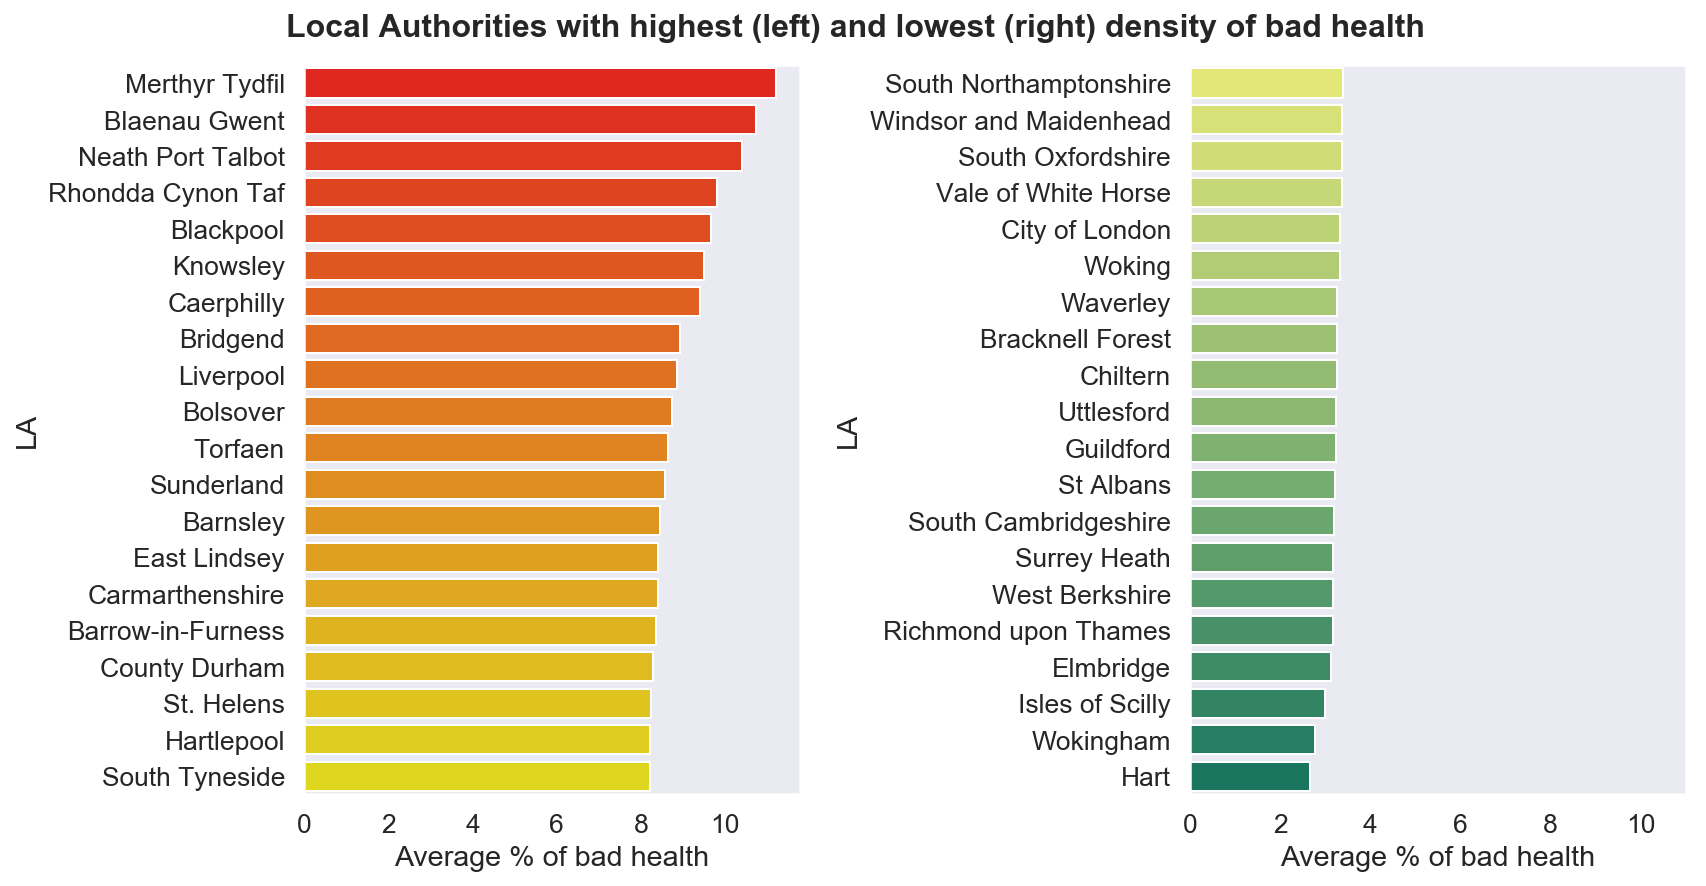

In [163]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))

sns.barplot(x='Average % of bad health', y=la_health.index[:20], data=la_health.head(20), 
            orient='h', palette='autumn', ax=ax[0])

sns.barplot(x='Average % of bad health', y=la_health.index[-20:], data=la_health.tail(20), 
            orient='h', palette='summer_r', ax=ax[1])

ax[1].set_xlim(0, 11)
plt.suptitle('Local Authorities with highest (left) and lowest (right) density of bad health', y=1.02, 
             fontsize=16, fontweight='bold')

plt.tight_layout()
#plt.savefig('images/la_health.png', dpi=200, bbox_inches='tight')
plt.show()

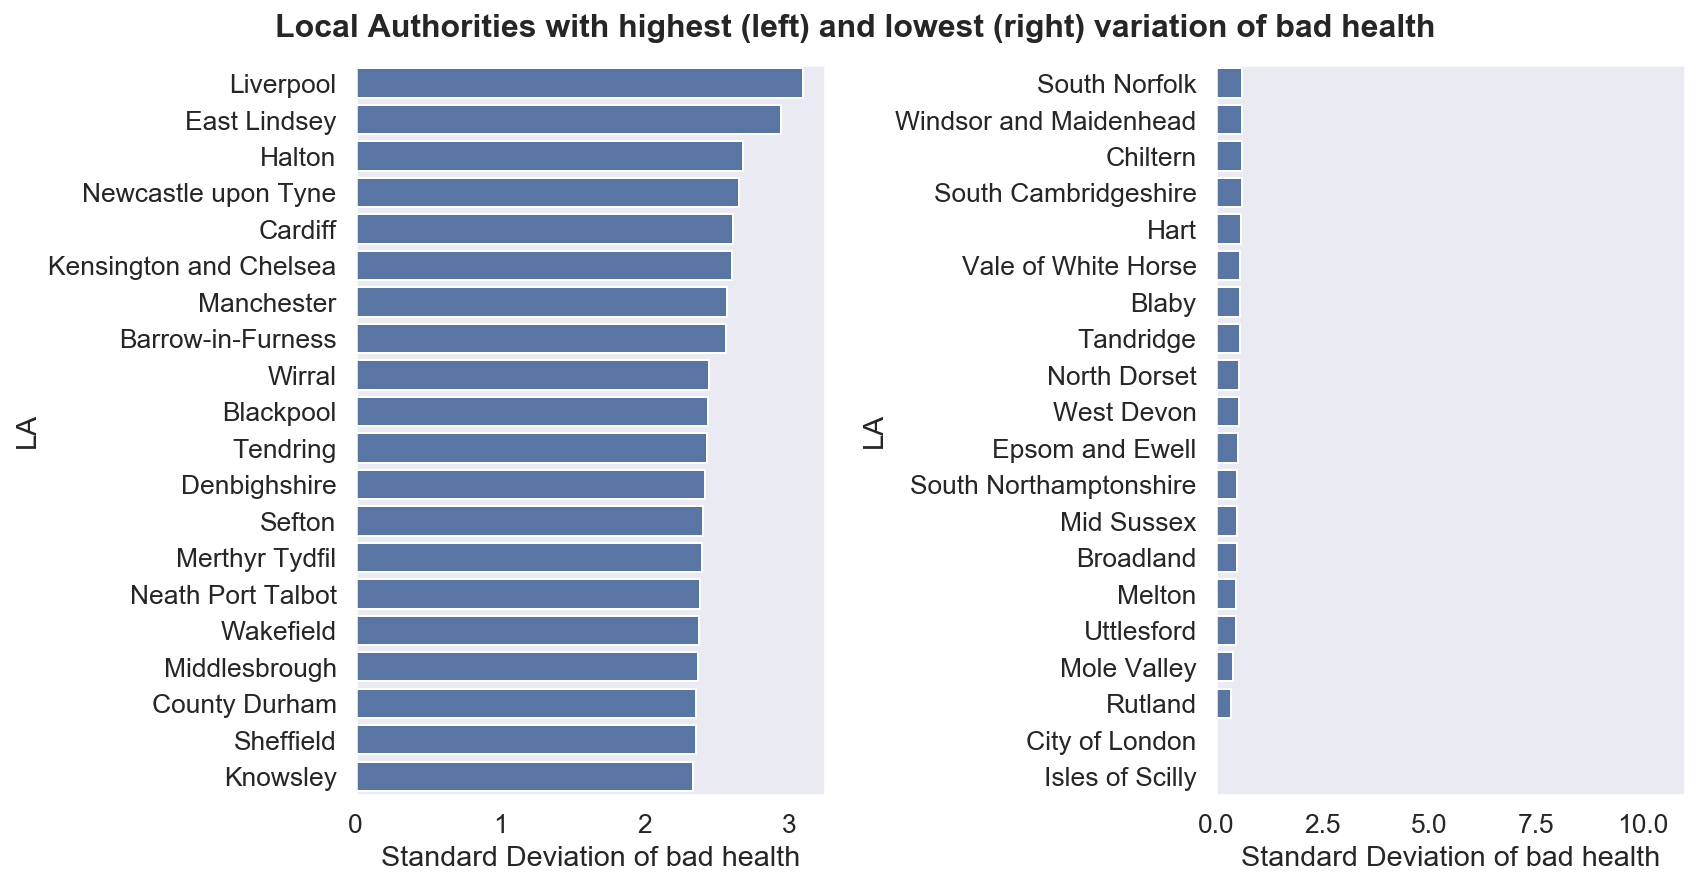

In [22]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 6))

sns.barplot(x='Standard Deviation of bad health', y=la_health_std.index[:20], data=la_health_std.head(20), 
            orient='h', color='b', ax=ax[0])

sns.barplot(x='Standard Deviation of bad health', y=la_health_std.index[-20:], data=la_health_std.tail(20), 
            orient='h', color='b', ax=ax[1])

ax[1].set_xlim(0, 11)
plt.suptitle('Local Authorities with highest (left) and lowest (right) variation of bad health', y=1.02, 
             fontsize=16,fontweight='bold')

plt.tight_layout()
plt.savefig('images/la_health_deviation_single_colour.png', dpi=200)
plt.show()

<a id="health_distributions"></a>
##### Health distributions

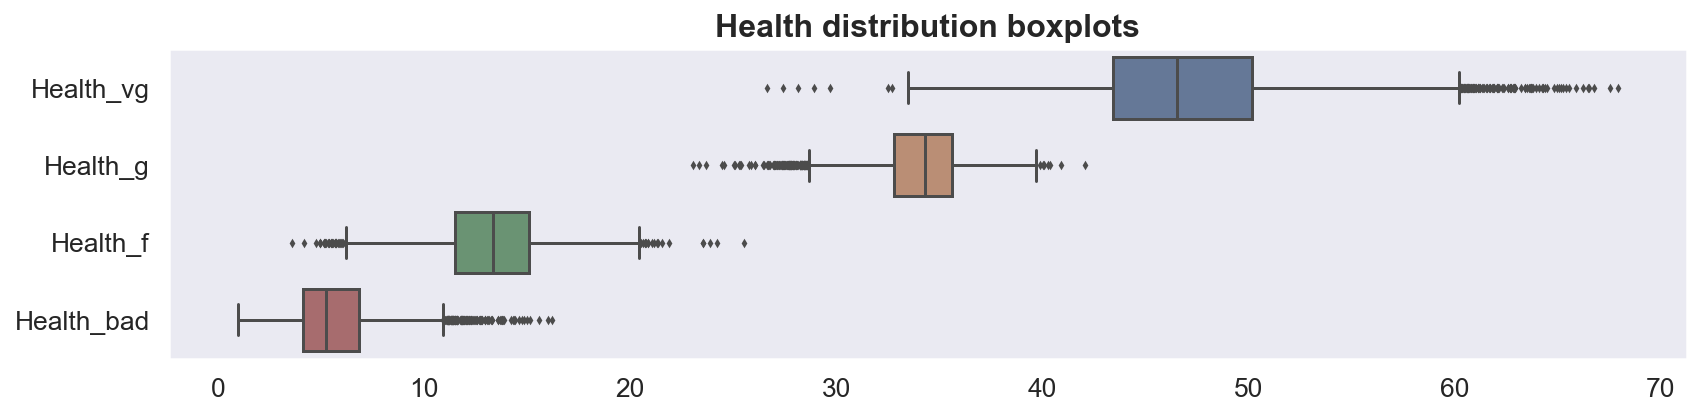

In [26]:
fig, ax = plt.subplots(figsize=(12,3))
sns.boxplot(data=target, saturation=0.5, orient='h', fliersize=2 )
ax.set_title('Health distribution boxplots', fontsize=16, fontweight='bold')
plt.tight_layout()
#plt.savefig('images/health_distributions.png', dpi=200)

plt.show()

<b>Notes: </b> This health data is full of outliers - I'll need to think carefully about how exactly it will be best to model.


In [13]:
#According to the box plot, I only have outliers on the right / high end. How many are there? 
outlier_health_mask = (target.Health_bad > (target.Health_bad.mean() + 3*target.Health_bad.std()))

In [14]:
target.Health_bad[outlier_health_mask].shape[0]

61

<a id="mapping"></a>
##### Mapping Health 

<b>Notes: </b> I thought it would be interesting to experiment with mapping directly in python (rather than using a software like Tableau). Here I set up a function to plot an individual shape from coordinates, then iterate over the dataframe to plot each output area. The color of each area is mapped to a diverging color palette, representing the proportion of bad health within the area. The optional argument 's' is for adding text to the map. 
    
Areas in red have the highest proportion of bad health, and areas in green have the lowest proportion of bad health. Remembering that all the health variables add up to 100%, we can surmise that the areas plotted in green will then  have high proportions of good health. 


In [13]:
shp_path = 'shapefiles/infuse_msoa_lyr_2011_clipped.shp'
sf = shp.Reader(shp_path)

In [14]:

def plot_shape(id, s=None, color='r', alpha=1):
    """ PLOTS A SINGLE SHAPE """
    
    shape = sf.shape(id)
    
    x_lon = np.zeros((len(shape.points),1))
    y_lat = np.zeros((len(shape.points),1))
    
    for i in range(len(shape.points)):
        x_lon[i] = shape.points[i][0]
        y_lat[i] = shape.points[i][1]
        
    plt.plot(x_lon,y_lat, color, alpha=alpha) 
    plt.fill(x_lon,y_lat, color, alpha=alpha)
    
    x0 = np.mean(x_lon)
    y0 = np.mean(y_lat)

    plt.text(x0, y0, s, fontsize=12, fontweight='bold')

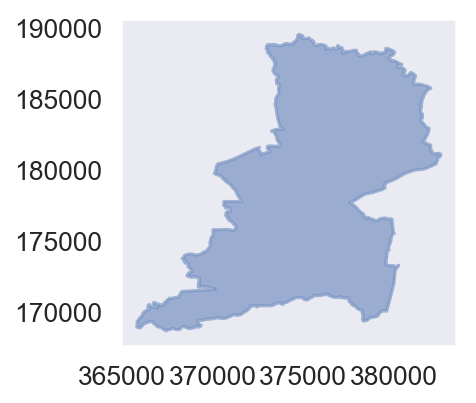

In [15]:
#testing on one of the MSOAs:

fig, ax = plt.subplots(figsize = (3,3))
plot_shape(0, color='b', alpha=0.5)

In [16]:
target[['Health_bad']].describe()

Health_bad
count  7201.000000
mean      5.635718
std       2.099420
min       0.948055
25%       4.106814
50%       5.243360
75%       6.828303
max      16.196340

In [17]:
# diverging color palette chosen with the help of Color Brewer: 
# http://colorbrewer2.org/#type=diverging&scheme=RdYlGn&n=6

def make_colors(x): 
    """ RETURNS DIVERGING COLOR PALETTE FROM GREEN (low values) TO RED (high values)"""
    if x == np.nan:
        return '#bdbdbd'
    if x < 2: 
        return '#1a9850'
    elif x < 3:
        return '#91cf60'
    elif x < 4.11:
        return '#d9ef8b'
    elif x < 5.24: 
        return '#fee08b'
    elif x < 6.82:
        return '#fc8d59'
    else:
        return '#d73027'

In [18]:
colors = ['#1a9850', '#91cf60', '#d9ef8b', '#fee08b', '#fc8d59', '#d73027']

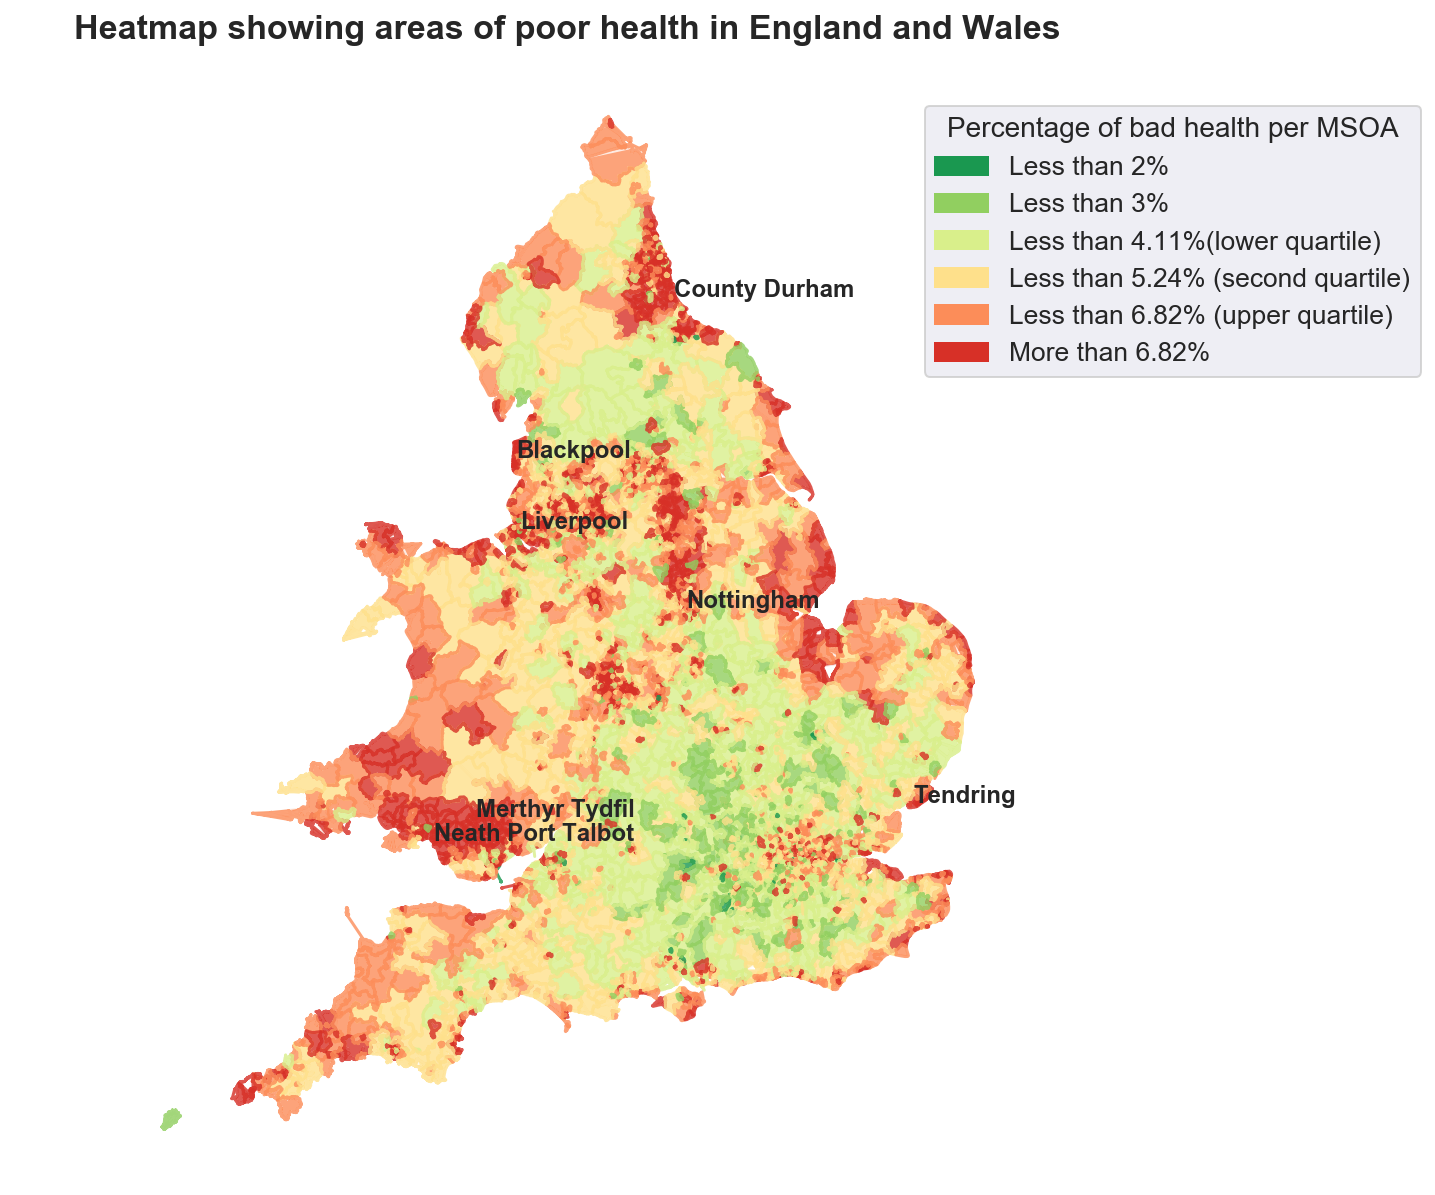

In [175]:
fig, ax = plt.subplots(figsize=(8, 10))

#I'm looping over all the MSOAs, plotting each area, and adding the name of the local authority if the MSOA is in 
#particularly bad health. 

written = []
for i in tqdm_notebook(range(target.shape[0])):
    color = make_colors(target.Health_bad[i])
    if target.Health_bad[i] < 14:
        plot_shape(i, s=None, color = color, alpha=0.8)       
    else: 
        text = sf.records()[i][1][:-4]
        if text not in written: 
            plot_shape(i, s=text, color = color, alpha=0.8)
            written.append(text)
        else:
            plot_shape(i, s=None, color = color, alpha=0.8)
        
        
ax.set_title('Heatmap showing areas of poor health in England and Wales', fontsize=17, fontweight='bold')   
ax.set_ylim(0, 700000)
plt.axis('off')

#setting a custom legend
less_2 = mpatches.Patch(color='#1a9850', label='Less than 2%')
less_3 = mpatches.Patch(color='#91cf60', label='Less than 3%')
less_4 = mpatches.Patch(color='#d9ef8b', label='Less than 4.11%(lower quartile)')
less_5 = mpatches.Patch(color='#fee08b', label='Less than 5.24% (second quartile)')
less_6 = mpatches.Patch(color='#fc8d59', label='Less than 6.82% (upper quartile)')
highest = mpatches.Patch(color='#d73027', label='More than 6.82%')
plt.legend(handles=[less_2, less_3, less_4, less_5, less_6, highest], loc=[0.9,0.7], 
          title='Percentage of bad health per MSOA', title_fontsize=14)
legend_marks = mpatches.Patch()

# plt.savefig('images/health_map_with_legend', dpi=200, bbox_inches='tight')
plt.show()

<b>Notes:</b> It is really interesting to see how areas of poor health are more concentrated at the fringes. Wales looks particularly bad, as does the area around Newcastle, and the Lincolnshire coast.

There is a strong concentration of green around Greater London and it's surrounds, as well as the Yorkshire Dales. London also has noticeable areas of poor health scattered within the city. This is unsurprising given the high levels of inequality in the city. If of interest, more in depth data can be found in the Trust for London's [London Poverty Profile.](https://www.trustforlondon.org.uk/data/topics/inequality/) 

In [176]:
data.head(2)

GeographyCode                                             coords  \
0     E02003113  [(368710.883, 173101.639), (368667.312, 173141...   
1     E02001245  [(393356.551, 398022.687), (393367.892, 398040...   

                        MSOA     LACode                     LA  Tot_people  \
0  South Gloucestershire 024  E06000025  South Gloucestershire     10167.0   
1               Tameside 017  E08000008               Tameside      7848.0   

   Tot_area_hect    Density    Female%  Household_living%     Qual_0  \
0       17027.36   0.597098  50.477034          99.508213  18.240807   
1         262.79  29.864150  50.509684          99.120795  27.859516   

      Qual_1     Qual_2    Qual_A     Qual_3     Qual_4  Qual_Other  \
0  12.821437  15.176640  4.073540  11.860130  34.318673    3.508772   
1  16.231609  18.193324  4.034172  13.257396  16.658757    3.765227   

   couple_living  
0      67.665901  
1      55.525348

<a id="notes before modelling"></a>
#### Final notes before modelling

I have decided to approach this problem by running a regression model with the percentage of bad health ('health_bad') as my target variable. As these four health variables are designed to add up to 100%, they are correlated (i.e. areas with a high percentage of bad health will have lower percentages of fair and good health.)
    
Although the boxplot and mask above showed that the 'health_bad' distribution has 61 outliers, I don't want to remove these as they are particularly important to identify.
    
Thinking in terms of policy implementation to improve areas of poor health, it is most important to be able to identify the worst affected areas, and the features or conditions that influence them, even if this means that my model performs less well overall. 


In [15]:
y = target['Health_bad']
X = data.drop(columns = ['GeographyCode', 'coords', 'MSOA', 'LACode', 'LA', 'Qual_A'])

<a id="modelling"></a>

#### Modelling

In [16]:
#splitting my data into a train and a hold-out test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [17]:
#Instantiating a standar scaler, fitting on the train set, and transforming both the train and 
#test sets. I fit only on the train set, so that the test set remains 'unseen' data.

scaler = StandardScaler()
Xs_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns) 
Xs_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

<a id="linear regression" ></a>
##### Linear Regression: Basic, Lasso, Ridge, ElasticNet

As my target is continuous, I need to fit a regression model. Below I test four different regression models: 

    1) A basic Linear Regression with no added penalties
    2) A regression with Lasso penalty 
    3) A regression with Ridge penalty 
    4) An ElasticNet which has a combination of both the ridge and lasso penalties. 

Introducing these penalties into my model lowers the variance, but this has the effect of raising the bias. The models thus generalize better, but produce more error. I use the inbuilt cross validation functions to find the right bias / variance trade-off - the best compromise. 

The ridge and lasso penalties achieve this in slightly different ways, but the lasso is more drastic and likelier to drive some of the coefficients to zero (which cancels out the influence of those terms). 

In [18]:
#setting up a function to test different models 
def test_models(models, names, x_train, x_test, y_train, y_test): 
    
    """
    Print test and cross-validated train scores for different models 
    Arguments:
    names: List of model names as strings
    models: List of models to test
    x_train, x_test: x values to train and test the model on
    y_train, y_test: y values to train and test the model on
    """
    
    for model, name in list(zip(models, names)): 
        m = model
        m.fit(x_train, y_train)
        print(name)
        print('Test score: ', m.score(x_test, y_test))
        print('Cross validated score: ', cross_val_score(m, x_test, y_test, cv=5).mean())
        print('-'*42)

In [48]:
models = [LinearRegression(), 
          LassoCV(n_alphas=200, cv=5), 
          RidgeCV(alphas = np.logspace(1, 5, 200), cv=5), 
          ElasticNetCV(l1_ratio=[0.0001, 0.001, 0.01, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
                       alphas=np.logspace(-4, 4, 100), 
                       cv=5, max_iter=15000)]

names = ['Regular Linear Regression', 'LassoCV', 'RidgeCV', 'ElasticNetCV']

In [49]:
test_models(models, names, Xs_train, Xs_test, y_train, y_test)

Regular Linear Regression
Test score:  0.8247575437901236
Cross validated score:  0.8205727064024833
------------------------------------------
LassoCV
Test score:  0.8247359403575016
Cross validated score:  0.8208437280626015
------------------------------------------
RidgeCV
Test score:  0.8245702839696297
Cross validated score:  0.8193860108464417
------------------------------------------
ElasticNetCV
Test score:  0.8247748101072647
Cross validated score:  0.8204054389331228
------------------------------------------


<a id="investigating lasso"></a>
##### Investigating the Lasso Model 
<b>Notes: </b>We evaluate the best model by its cross-validated score. As the lasso (least absolute shrinkage and selection operator) has performed best I'll investigate this model further. 

A lasso penalty means that the sum of squared beta coefficients is added to the residual sum of squares (RSS), together forming the Loss Function the model is minimizing. The result is that some of the coefficients can be driven to zero. We will be interested in the Alpha parameter, the constant that multiplies the L1 (lasso) term, which determines the strength of the regularization penalty component. If this is very low coefficients are less likely to be driven to zero.  


In [29]:
lasso = LassoCV(n_alphas=200, cv=5)
lasso.fit(Xs_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=200, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [30]:
print('Alpha: ', lasso.alpha_) 
print('Intercept: ', lasso.intercept_)

Alpha:  0.001774987183918791
Intercept:  5.641751103343311


In [31]:
# The low alpha means that my regularization penalty is not adding much to the loss function. 

In [32]:
lasso_coefs = pd.DataFrame(list(zip(X_train.columns, lasso.coef_, abs(lasso.coef_))), 
             columns = ['Feature', 'Coef', 'Abs_coef']).sort_values(
             by='Abs_coef', ascending=False)

In [33]:
lasso_coefs

Feature      Coef  Abs_coef
9              Qual_4 -1.722124  1.722124
6              Qual_1 -1.221740  1.221740
8              Qual_3 -0.962104  0.962104
11      couple_living -0.926338  0.926338
10         Qual_Other -0.703358  0.703358
5              Qual_0  0.629280  0.629280
4   Household_living% -0.098496  0.098496
2             Density -0.058202  0.058202
1       Tot_area_hect -0.040361  0.040361
7              Qual_2 -0.026795  0.026795
3             Female% -0.012771  0.012771
0          Tot_people  0.002537  0.002537

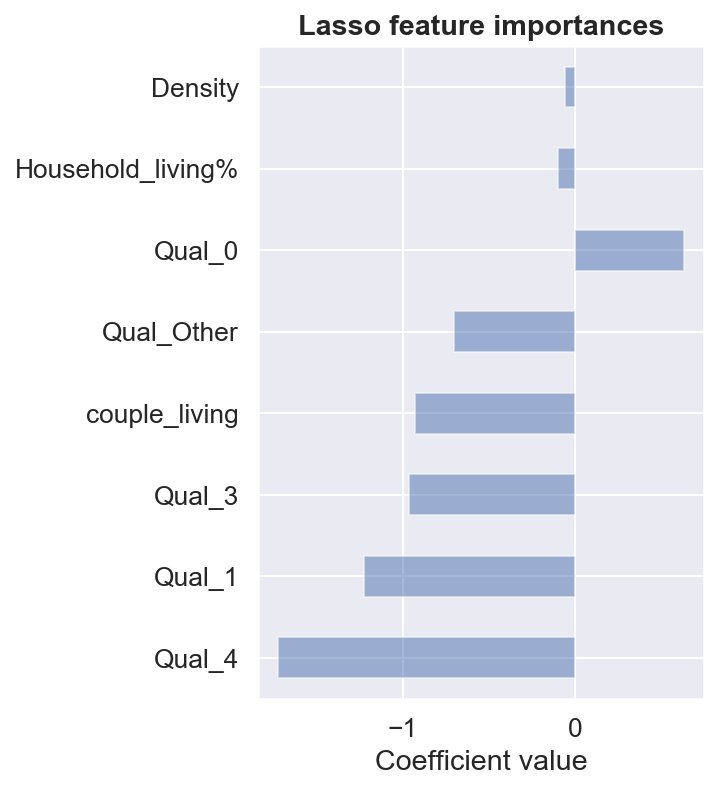

In [15]:
#and visualizing the feature importances: 
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(4,6))
lasso_coefs.Coef[:8].plot(kind='barh',ax=ax,alpha=0.5)
ax.set_yticklabels(lasso_coefs.Feature[:9].values)
ax.set_xlabel('Coefficient value')
ax.set_title('Lasso feature importances', fontweight='bold')
#plt.savefig('images/lasso_features', dpi=200, bbox_inches='tight')
plt.show()

<a id="feature importances"></a>
##### Notes on the Feature Importances

- Qual_4: percentage highest level of qualification: Level 4 qualifications and above: Bachelors degree or equivalent, and higher qualifications
        
- Qual_1: percentage highest level of qualification: Level 1 qualifications: 1-4 GCSEs or equivalent qualifications   

- Qual_3: percentage highest level of qualification: Level 3 qualifications: 2 or more A-levels or equivalent qualifications
        
- couple_living: percentage living in a couple - includes marriage, civil partnerships, cohabitation

- Qual_Other: percentage highest level of qualification: Other qualifications including foreign qualifications
        
- Qual_0: percentage no qualifications

- Household_living%: percentage lives in a household

- Density: density (number of persons per hectare)

  
Remember: I dropped Qual_A: percentage of the population whose highest qualification is an Apprenticeship. This is then represented in the mean value, from which these coefficients depart. 

The overall finding of this model is that education levels are strong indicators of a population's health. An area with a high proportion of its population without any qualifications is likelier to have higher levels of bad health. Conversely, any level of education adds to predicting lower levels of bad health, and the term that contributes most negatively to bad health within an area (i.e. contributes most positively to predicting better health) is the percentage of the area's population with tertiary qualifications. 

It is also interesting to see that the percentage of an area's population that is living in a couple contributes to a lower level of bad health. 

<a id="plotting residuals"></a>
##### Plotting the residuals

In [35]:
#Testing the distribution of the residuals: linear regression makes the assumption that the 
#residuals will be normally distributed, so I'm testing to see whether this is indeed the case. 
residuals = y_test - lasso.predict(Xs_test)
print(residuals.shape)
print(y_test.shape)

(1441,)
(1441,)


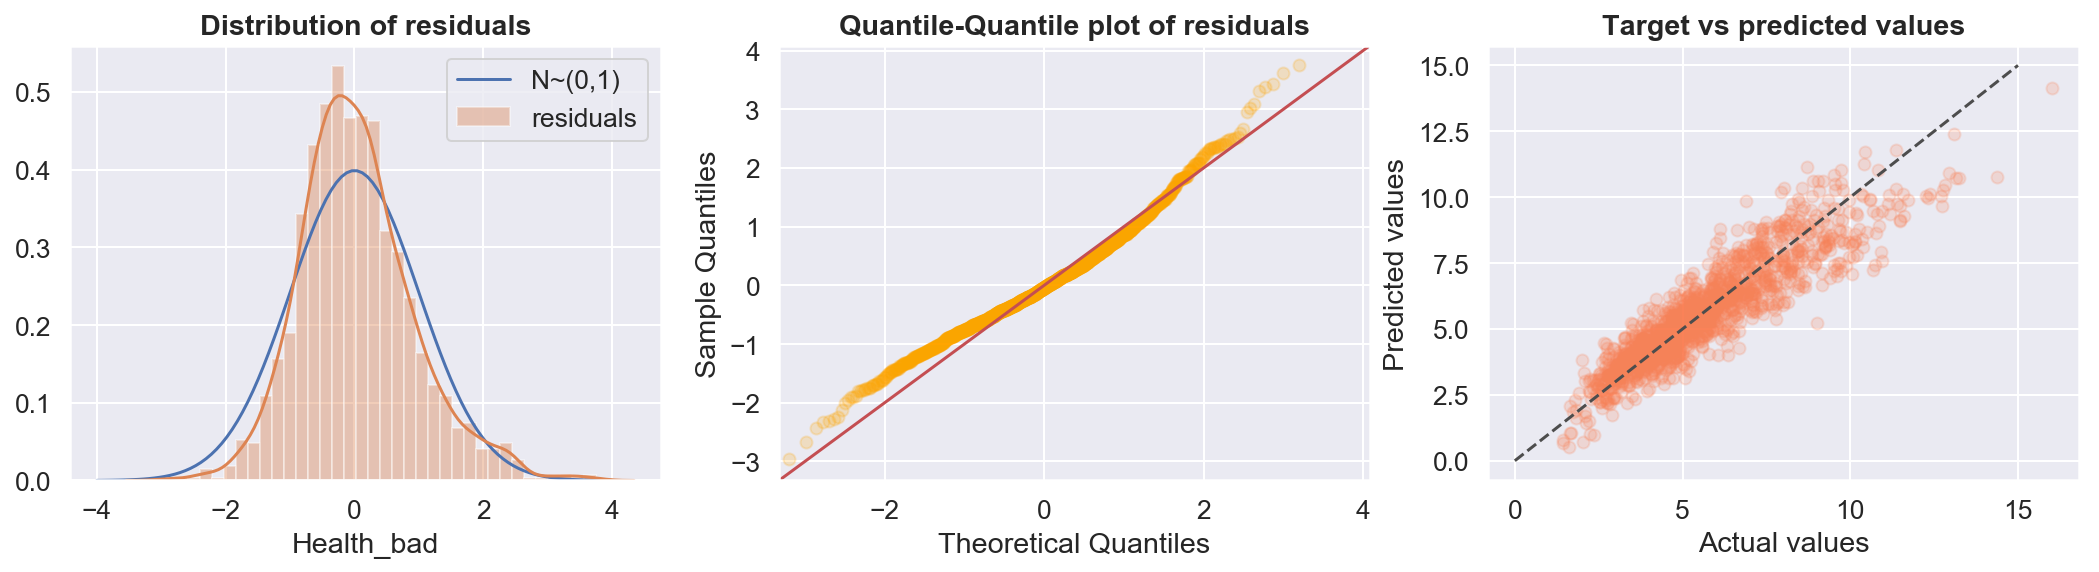

In [47]:
sns.set_style('darkgrid')
fig, ax = plt.subplots(ncols=3, figsize=(18,4))
x = np.linspace(-4,  4, 100)

ax[0].plot(x, stats.norm.pdf(x, 0, 1), label='N~(0,1)')
sns.distplot(residuals, label='residuals', ax=ax[0])
ax[0].set_title('Distribution of residuals', fontweight='bold')
ax[0].legend()

sm.qqplot(residuals, line='45', c='orange', alpha=0.2, ax=ax[1])
ax[1].set_title('Quantile-Quantile plot of residuals', fontweight='bold')


ax[2].scatter(y_test, lasso.predict(Xs_test), alpha=0.2, c='#FA8258')
ax[2].plot([0,15], [0,15], ls="--", c=".3")
ax[2].set_title('Target vs predicted values', fontweight='bold')
ax[2].set_xlabel('Actual values')
ax[2].set_ylabel('Predicted values')

plt.savefig('images/lasso_residual_distribution', dpi=200, bbox_inches='tight')
plt.show()

<a id="lasso notes"></a>
##### Notes
These are fairly normally distributed, but you can see that the model has been influenced by the extreme outliers of the target variable (visually represented in the boxplots - see EDA). 



<a id="other models"></a>
#### Testing other models 

As my target variable was continuous I started by exploring basic linear regression models, but now I'll try some other regressors. </i>

<a id="knn"></a>
##### KNeighborsRegressor

In [263]:
names = ['KNeighborsRegressor']
for i in range(3,12): 
    print('N_neighbors = {}'.format(i+1))
    knn = [KNeighborsRegressor(n_neighbors=(i+1))]
    test_models(knn, names, Xs_train, Xs_test, y_train, y_test)

N_neighbors = 4
KNeighborsRegressor
Test score:  0.794026575424537
Cross validated score:  0.7486053060411079
------------------------------------------
N_neighbors = 5
KNeighborsRegressor
Test score:  0.8046209555666034
Cross validated score:  0.7562721032695296
------------------------------------------
N_neighbors = 6
KNeighborsRegressor
Test score:  0.80541192909246
Cross validated score:  0.7546274346783133
------------------------------------------
N_neighbors = 7
KNeighborsRegressor
Test score:  0.8058502766921711
Cross validated score:  0.7595330290296138
------------------------------------------
N_neighbors = 8
KNeighborsRegressor
Test score:  0.8070161667496532
Cross validated score:  0.7576541452617354
------------------------------------------
N_neighbors = 9
KNeighborsRegressor
Test score:  0.80661722262564
Cross validated score:  0.757993130434115
------------------------------------------
N_neighbors = 10
KNeighborsRegressor
Test score:  0.8059253403318051
Cross validat

<i style="color:Tomato;">Cross validated scores don't match that of the Lasso model </i>

<a id="decision tree"></a>
##### DecisionTreeRegressor

In [264]:
names = ['Decision Tree Regressor']
for i in range(9): 
    dt = [DecisionTreeRegressor(max_depth=(i+1), random_state=1)]
    print('max_depth = {}'.format(i+1))
    test_models(dt, names, Xs_train, Xs_test, y_train, y_test)

max_depth = 1
Decision Tree Regressor
Test score:  0.4981557611349586
Cross validated score:  0.4917513003098586
------------------------------------------
max_depth = 2
Decision Tree Regressor
Test score:  0.6547035624789768
Cross validated score:  0.6420644407071899
------------------------------------------
max_depth = 3
Decision Tree Regressor
Test score:  0.6940673100613436
Cross validated score:  0.6685606789063632
------------------------------------------
max_depth = 4
Decision Tree Regressor
Test score:  0.7342719561563559
Cross validated score:  0.7105949380041074
------------------------------------------
max_depth = 5
Decision Tree Regressor
Test score:  0.7584919719879233
Cross validated score:  0.7237335114400788
------------------------------------------
max_depth = 6
Decision Tree Regressor
Test score:  0.7819957749684403
Cross validated score:  0.7185952531990728
------------------------------------------
max_depth = 7
Decision Tree Regressor
Test score:  0.79196050705

<i style="color:Tomato;">Cross validated scores don't match that of the Lasso model - but visualising for interest </i>

In [265]:
#visualizing the best tree: 
dt = DecisionTreeRegressor(max_depth=5, random_state=1)
dt.fit(Xs_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

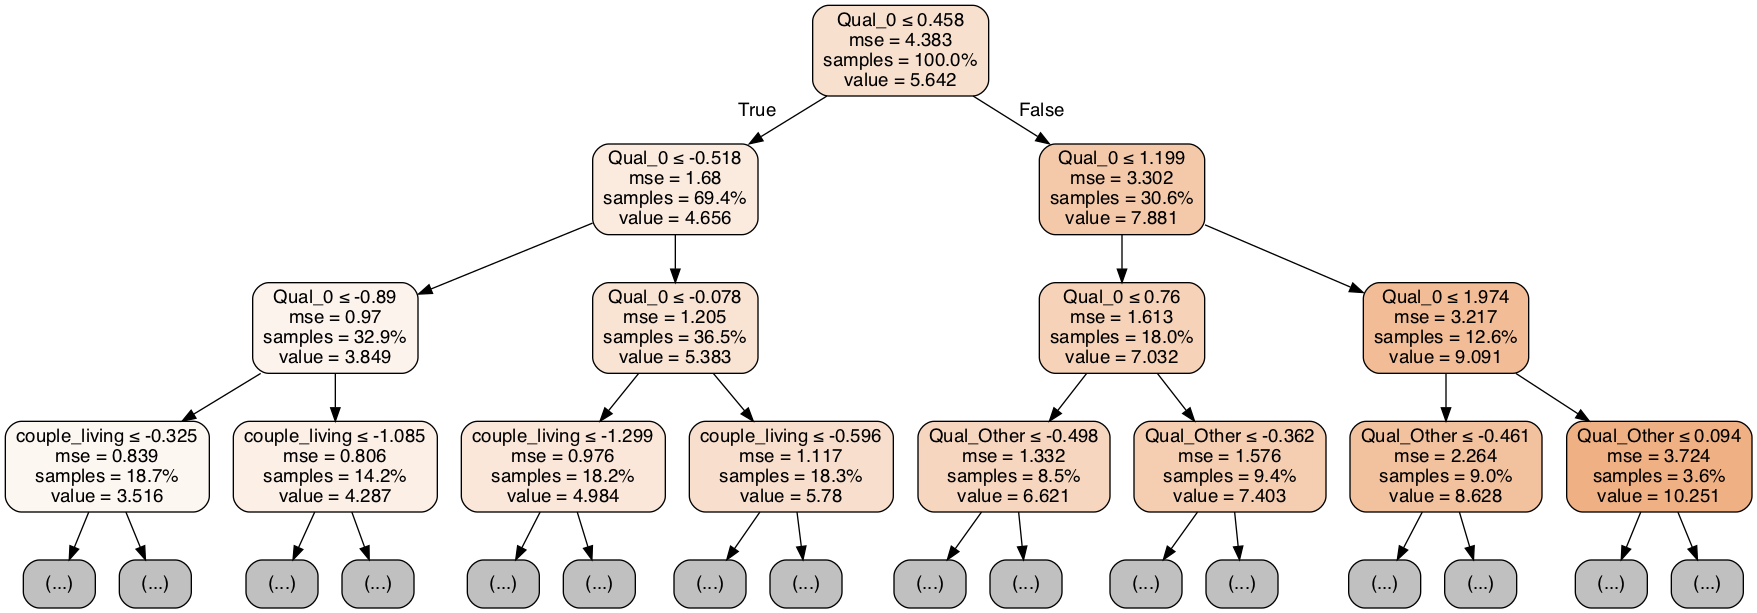

In [267]:
dot_data = StringIO()
export_graphviz(dt,
                out_file=dot_data,
                max_depth=3,
                filled=True,
                rounded=True,
                special_characters=True,
                proportion=True,
                feature_names=X_train.columns
                )

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

#graph.write_png("images/decision_tree.png")
Image(graph.create_png())

This is a greedy algorithm, meaning that at each point in the tree, the decision made is the best decision at that point, regardless of whether this leads to the best decision overall. There is no insight into how this local decision this could affect later decisions or the overall performance of the model. Interestingly, the percentage of the population with zero qualifications is the only deciding feature for the first 3 levels of decisions. 

<a id="random forest"></a>
##### RandomForestRegressor

In [268]:
names = ['RandomForestRegressor']
for i in range(5,15): 
    rf = [RandomForestRegressor(max_depth=(i+1), random_state=1)]
    print('max_depth = {}'.format(i+1))
    test_models(rf, names, Xs_train, Xs_test, y_train, y_test)

max_depth = 6
RandomForestRegressor
Test score:  0.8208023373558134
Cross validated score:  0.7951310096981723
------------------------------------------
max_depth = 7
RandomForestRegressor
Test score:  0.8276699533582796
Cross validated score:  0.7971391116476472
------------------------------------------
max_depth = 8
RandomForestRegressor
Test score:  0.8315350757211598
Cross validated score:  0.7937318034388247
------------------------------------------
max_depth = 9
RandomForestRegressor
Test score:  0.8346277074843442
Cross validated score:  0.7928727273593512
------------------------------------------
max_depth = 10
RandomForestRegressor
Test score:  0.8350302802197495
Cross validated score:  0.7942857837087829
------------------------------------------
max_depth = 11
RandomForestRegressor
Test score:  0.8350025202886489
Cross validated score:  0.7927061298074999
------------------------------------------
max_depth = 12
RandomForestRegressor
Test score:  0.8361479531214857
Cross

<i style="color:Tomato;">Cross validated scores don't match that of the Lasso model </i>

<a id="bagging"></a>
##### BaggingRegressor

In [26]:
model = BaggingRegressor(random_state=0)
model_params = {'n_estimators': [10, 16, 20, 25, 30], 
                'max_samples': [0.6, 0.7, 0.8, 0.9, 1], 
                'max_features': [0.6, 0.7, 0.8, 0.9, 1]}

In [27]:
gs = GridSearchCV(model, model_params, verbose=1, cv=5, n_jobs=3)

In [28]:
gs.fit(Xs_train, y_train)

Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    5.5s
[Parallel(n_jobs=3)]: Done 239 tasks      | elapsed:   36.8s
[Parallel(n_jobs=3)]: Done 625 out of 625 | elapsed:  1.4min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=10, n_jobs=None, oob_score=False, random_state=0,
         verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=3,
       param_grid={'n_estimators': [10, 16, 20, 25, 30], 'max_samples': [0.6, 0.7, 0.8, 0.9, 1], 'max_features': [0.6, 0.7, 0.8, 0.9, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [29]:
#This is actually slightly better than my Lasso - but as it's a blackbox model I'll stick with the Lasso 
gs.best_score_

0.8361711569039258

In [30]:
best_model = gs.best_estimator_

In [31]:
best_model.get_params

<bound method BaseEstimator.get_params of BaggingRegressor(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=0.9, max_samples=0.6,
         n_estimators=30, n_jobs=None, oob_score=False, random_state=0,
         verbose=0, warm_start=False)>

In [32]:
best_model.score(Xs_test, y_test)

0.835823128317299

<b>Notes: </b>This score is actually comparable to my Lasso model, but because it is a black-box model (i.e. we cannot tell exactly which features have influenced the modelling decisisions), I won't investigate further. Remembering that the aim of this model is to inform policy decisions, being able to interpret the model is a crucial component of judging its value.

<a id="bayesian"></a>
#### Bayesian Modelling

I'm happy that regression is providing a good model, but now I'm interested in how much trust I can place in a model and it's coefficients. For this I'll make use of the PyMC3 package to perform Bayesian Linear Modelling.

The MC in PyMC3 refers to the numeral method used to fit the models, Markov chain Monte Carlo (MCMC). Monte Carlo refers to the process of repeated random sampling to obtain numerical results, and the Markov chain part refers to a series of linked events, where what happens next depends only on the current state of the system. (Thanks Wikipedia! see [here](https://en.wikipedia.org/wiki/Monte_Carlo_method) and [here](https://en.wikipedia.org/wiki/Markov_chain).) 

The results of this model won't just be a list of coefficients / model parameters like I had for my lasso model. We will get most likely estimates (MAP, or <i>maximum a posteriori</i> estimates) for the parameters and distributions around these MAP estimates. These distributions express levels of uncertainty in the model, and it is why I have chosen to explore a Bayesian approach. When dealing with something like health, it is important to understand how certain or uncertain we are about what the model is telling us, before we make decisions that could affect people's health based on the results. 



In [25]:
import pymc3 as pm

In [26]:
Xs_train.head(2)

Tot_people  Tot_area_hect   Density   Female%  Household_living%    Qual_0  \
0   -0.952698      -0.390943  3.642469 -0.146532           0.319200 -1.130442   
1    0.756477      -0.268913 -0.555878  0.398697          -2.056803 -1.375578   

     Qual_1    Qual_2    Qual_3    Qual_4  Qual_Other  couple_living  
0 -2.013871 -2.654698  0.317027  1.741519    1.289803      -2.792010  
1 -1.763480 -1.441271  1.946209  1.104786    0.706027      -1.184007

In [27]:
df_bayes = Xs_train.copy()
df_bayes.shape

(5760, 12)

In [28]:
y_bayes = y_train.copy().reset_index(drop=True) 
#resetting the index so as not to get NaN values when I add this to the below dataframe

In [29]:
df_bayes['y'] = y_bayes
df_bayes.head(2)

Tot_people  Tot_area_hect   Density   Female%  Household_living%    Qual_0  \
0   -0.952698      -0.390943  3.642469 -0.146532           0.319200 -1.130442   
1    0.756477      -0.268913 -0.555878  0.398697          -2.056803 -1.375578   

     Qual_1    Qual_2    Qual_3    Qual_4  Qual_Other  couple_living         y  
0 -2.013871 -2.654698  0.317027  1.741519    1.289803      -2.792010  5.325255  
1 -1.763480 -1.441271  1.946209  1.104786    0.706027      -1.184007  3.549639

In [30]:
new_cols = df_bayes.columns.copy()
#getting rid of the percentage signs as the pymc3 package doesn't like them. 
new_cols = [col.strip('%') for col in new_cols]
df_bayes.columns = new_cols

<a id="set up"></a>
##### Setting up the model 

To set up the model, I need to define a set of 'priors', prior beliefs in what the distribution of my model parameters look like. Then I define how the model is related to these priors, my likelihood function. 

I set up the priors of the beta coefficients with a Laplace distribution, as this most closely simulates the lasso penalty of my best model in sklearn. I've plotted the Laplace distribution in comparison to a Gaussian / normal distribution below. The sharp point of the Laplace distribution is what makes it similar to the lasso penalty, which can force coefficients to zero. 

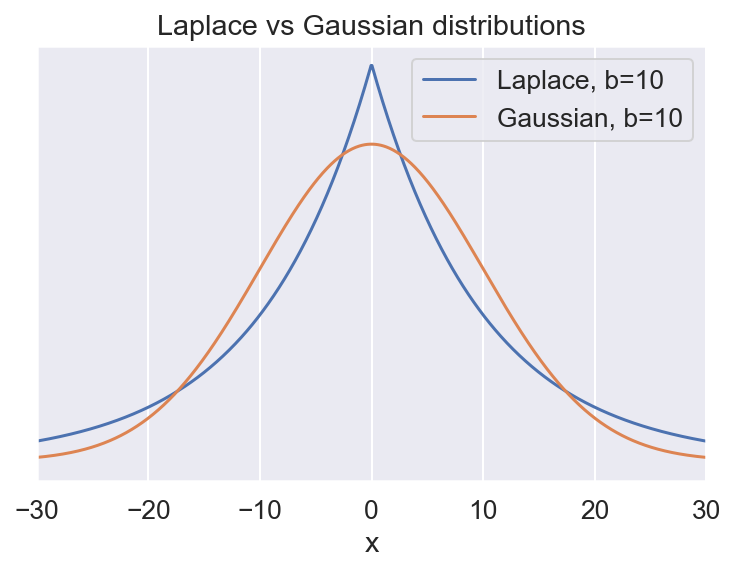

In [178]:
plt.figure(figsize=(6, 4))
x_values = np.linspace(-40, 40, 1000)

laplace = stats.laplace.pdf(x_values, scale=10)
plt.plot(x_values, laplace, label='Laplace, b=10')

gaussian = stats.norm.pdf(x_values, scale=10)
plt.plot(x_values, gaussian, label='Gaussian, b=10')
plt.xlabel('x')
plt.yticks([])
plt.title('Laplace vs Gaussian distributions')
plt.legend()
plt.xlim(-30, 30)
plt.savefig('images/Laplace_distributions.png', dpi=200)

plt.show()

In [31]:
with pm.Model() as reg_laplace:

    #defining the priors
    y_std = pm.Uniform('error_std', lower=0.01, upper=10.)
    intercept = pm.Normal('intercept', mu=df_bayes.y.mean(), sd=df_bayes.y.std())
    Tot_people_beta = pm.Laplace('Tot_people_beta', mu=0, b=10)
    Tot_area_hect_beta = pm.Laplace('Tot_area_hect_beta', mu=0, b=10)
    Density_beta = pm.Laplace('Density_beta', mu=0, b=10)
    Female_beta = pm.Laplace('Female_beta', mu=0, b=10)
    Household_living_beta = pm.Laplace('Household_living_beta', mu=0, b=10)
    Qual_0_beta = pm.Laplace('Qual_0_beta', mu=0, b=10)
    Qual_1_beta = pm.Laplace('Qual_1_beta', mu=0, b=10)
    Qual_2_beta = pm.Laplace('Qual_2_beta', mu=0, b=10)
    Qual_3_beta = pm.Laplace('Qual_3_beta', mu=0, b=10)
    Qual_4_beta = pm.Laplace('Qual_4_beta', mu=0, b=10)
    Qual_Other_beta = pm.Laplace('Qual_Other_beta', mu=0, b=10)
    couple_living_beta = pm.Laplace('couple_living_beta', mu=0, b=10)

    #defining the likelihood 
    E_y = pm.Normal('y_mean',
                    mu=intercept + (Tot_people_beta * df_bayes.Tot_people) + 
                    (Tot_area_hect_beta * df_bayes.Tot_area_hect) + 
                    (Density_beta * df_bayes.Density) + 
                    (Female_beta * df_bayes.Female) + 
                    (Household_living_beta * df_bayes.Household_living) + 
                    (Qual_0_beta * df_bayes.Qual_0) + 
                    (Qual_1_beta * df_bayes.Qual_1) + 
                    (Qual_2_beta * df_bayes.Qual_2) + 
                    (Qual_3_beta * df_bayes.Qual_3) + 
                    (Qual_4_beta * df_bayes.Qual_4) + 
                    (Qual_Other_beta * df_bayes.Qual_Other) + 
                    (couple_living_beta * df_bayes.couple_living),               
                    sd=y_std,
                    observed=df_bayes.y)

In [32]:
# Here I fit the model, which is essentially held in the 'trace'. The tuning parameter is set quite high -
# this slices off the initial parts of the trace, because it often starts far away from the best estimates. 
    #have increased the target_accept from default of 0.8


with reg_laplace:
    trace_laplace = pm.sample(6000, tune=2500, n_jobs=3, 
                      nuts_kwargs={'target_accept':0.95})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [couple_living_beta, Qual_Other_beta, Qual_4_beta, Qual_3_beta, Qual_2_beta, Qual_1_beta, Qual_0_beta, Household_living_beta, Female_beta, Density_beta, Tot_area_hect_beta, Tot_people_beta, intercept, error_std]
Sampling 2 chains: 100%|██████████| 17000/17000 [14:30<00:00, 19.54draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [131]:
trace_laplace[0] #viewing just one element of the trace

{'error_std_interval__': -2.3844028299727196,
 'intercept': 5.634331438767819,
 'Tot_people_beta': 0.01397614009419024,
 'Tot_area_hect_beta': -0.02891569746517367,
 'Density_beta': -0.07156717300385017,
 'Female_beta': -0.007830496151675177,
 'Household_living_beta': -0.11247509494426036,
 'Qual_0_beta': 0.26582706558837393,
 'Qual_1_beta': -1.353782777932763,
 'Qual_2_beta': -0.1541641319735399,
 'Qual_3_beta': -1.15055997504885,
 'Qual_4_beta': -2.210603877472272,
 'Qual_Other_beta': -0.8475067945984079,
 'couple_living_beta': -0.9742964628539664,
 'error_std': 0.8528544746648173}

In [134]:
len(trace_laplace)

6000

<a id="posteriors"></a>
##### Visualizing the posteriors

PyMC3 automatically adds information about the 95% 'credible interval' of these parameters, or the Highest Posterior Density interval (HPD). The 95% HPD says that the 95% highest density points on the distribution fall within that range.

I have also chosen to show the mode rather than the mean for the posterior distributions. If any coefficients have been driven to zero by the prior Laplace distribution, the mode will show this better than the mean. 


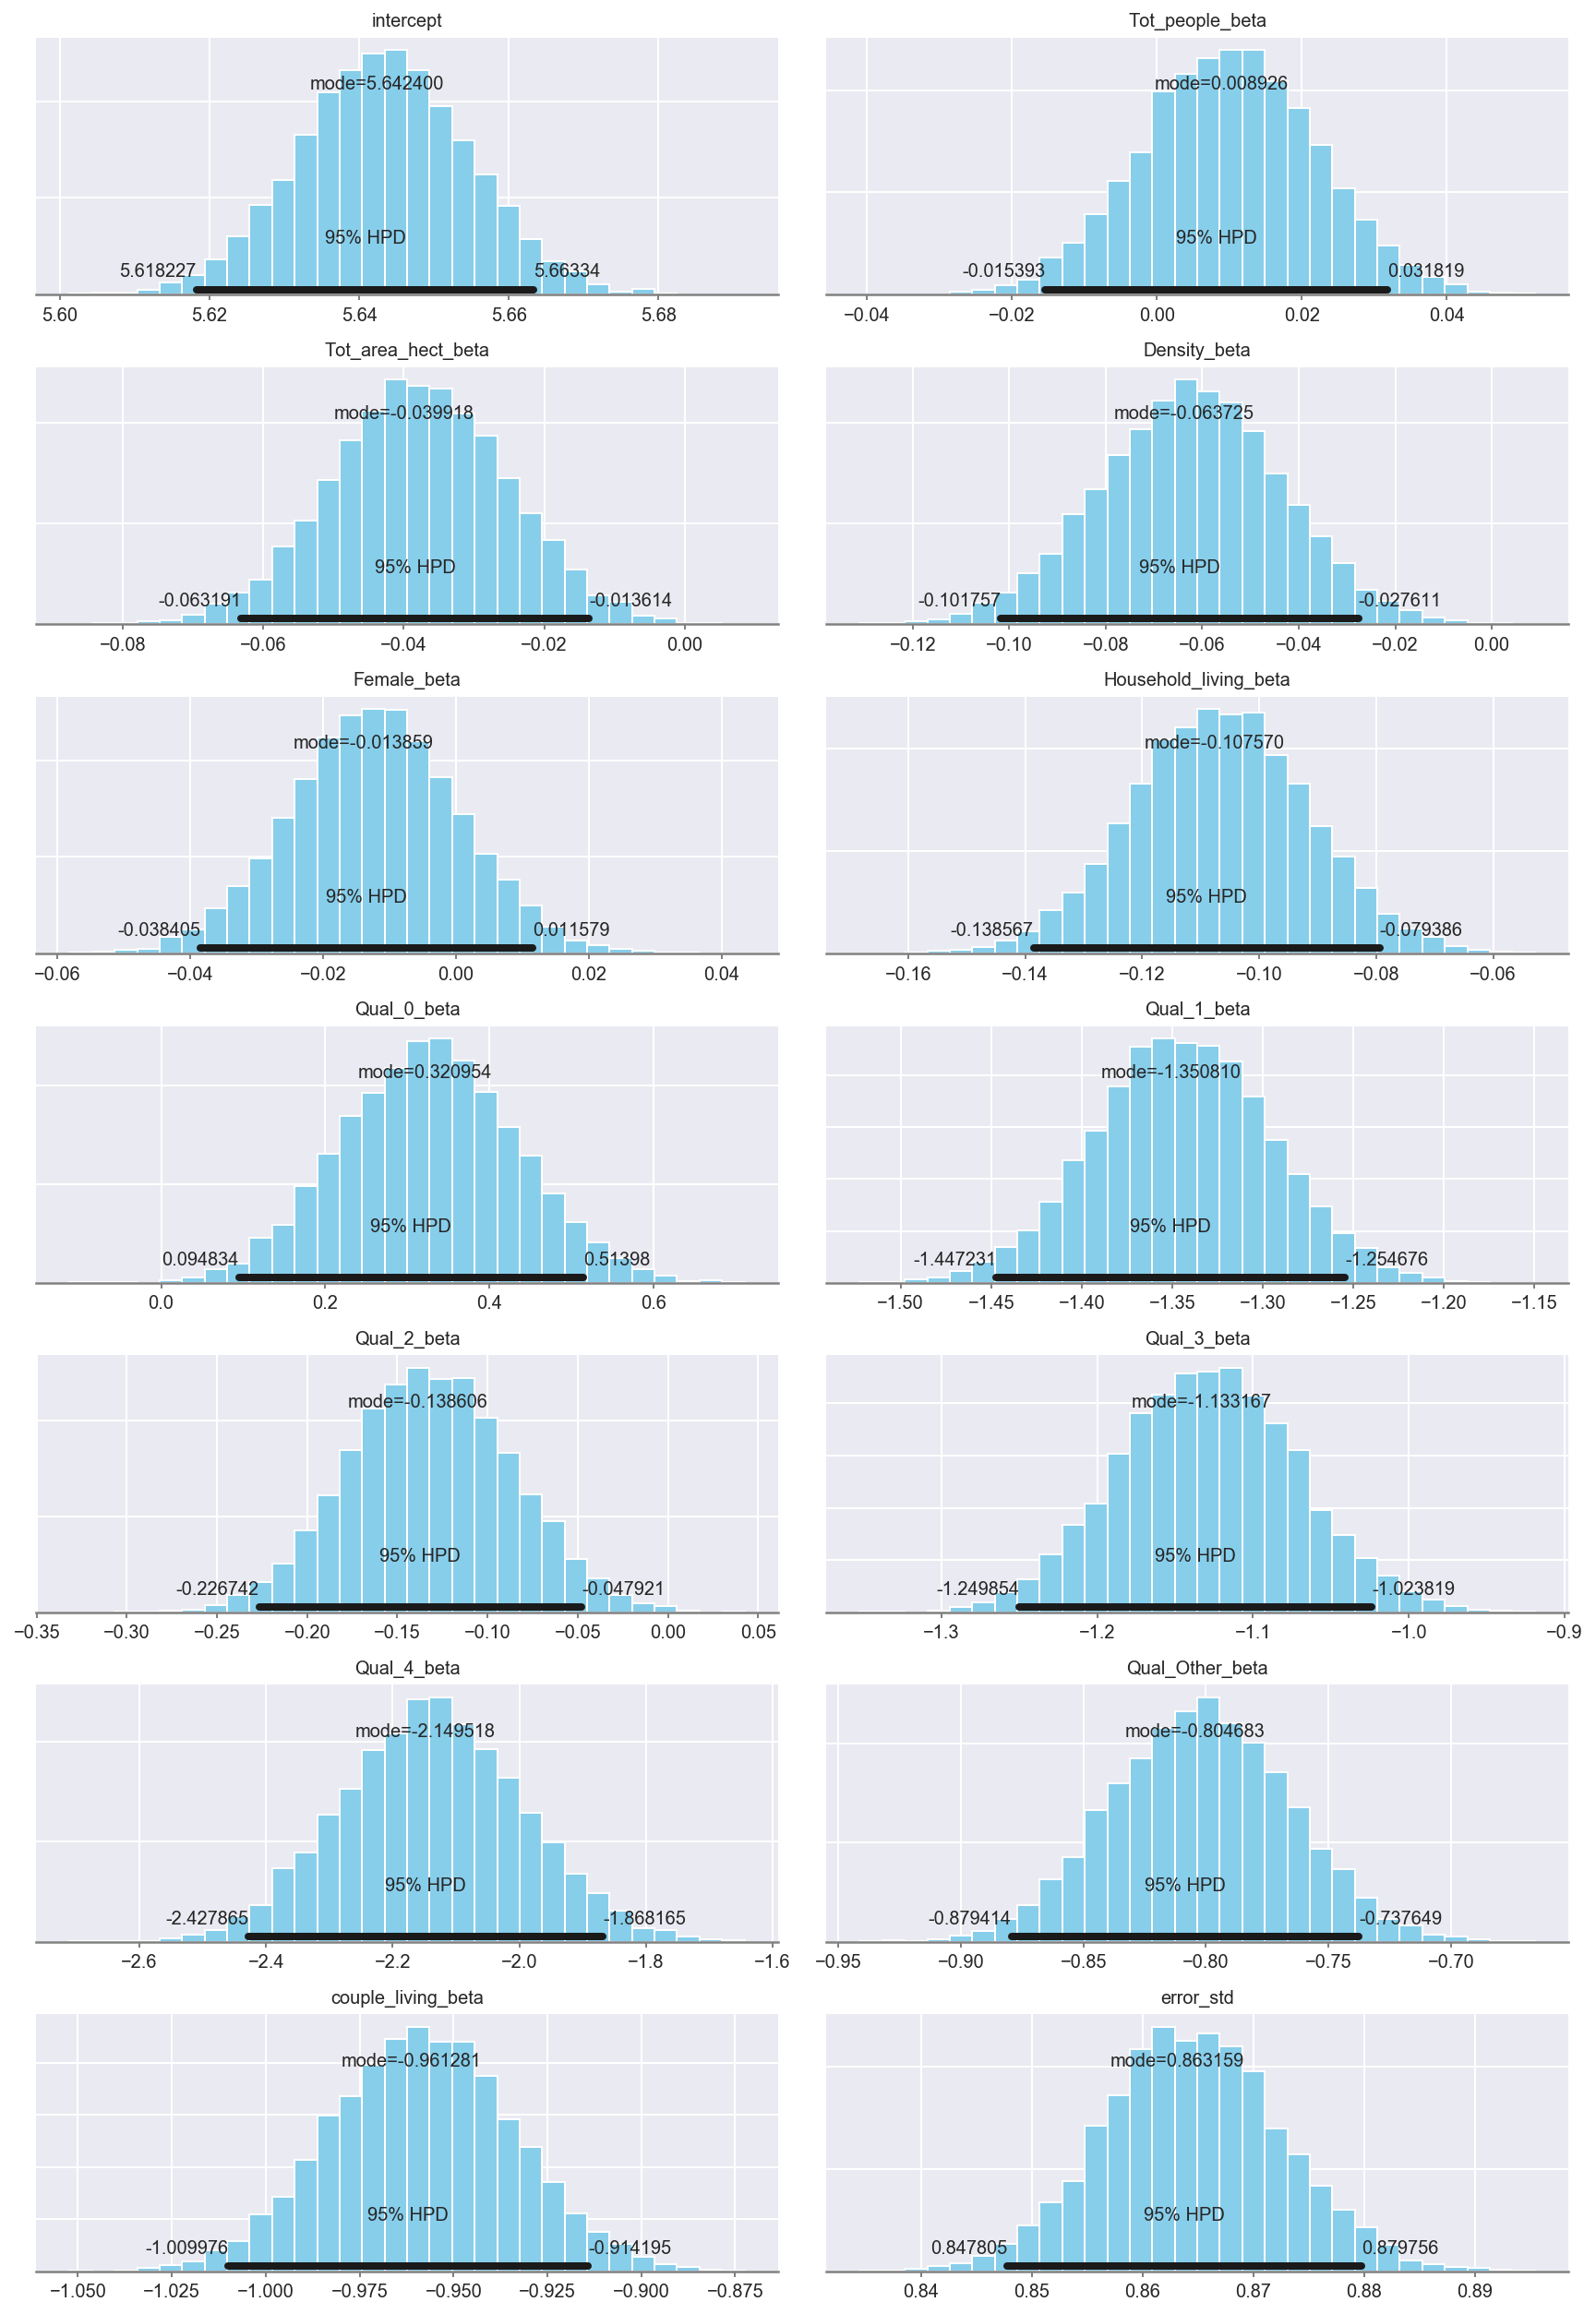

In [183]:
pm.plot_posterior(trace_laplace, color='#87ceeb', point_estimate='mode', round_to=6)
#plt.savefig('images/posteriors_laplace.png', dpi=200)
plt.show()

Traceplots (below) show us a similar story. There are kernel density estimates of the posterior distributions on the left, and we see how the chains evolve on the right. We want to see a lot of overlap in the two chains (colored blue and orange), because this means they are sampling similar points and we will have credible posterior distributions. 


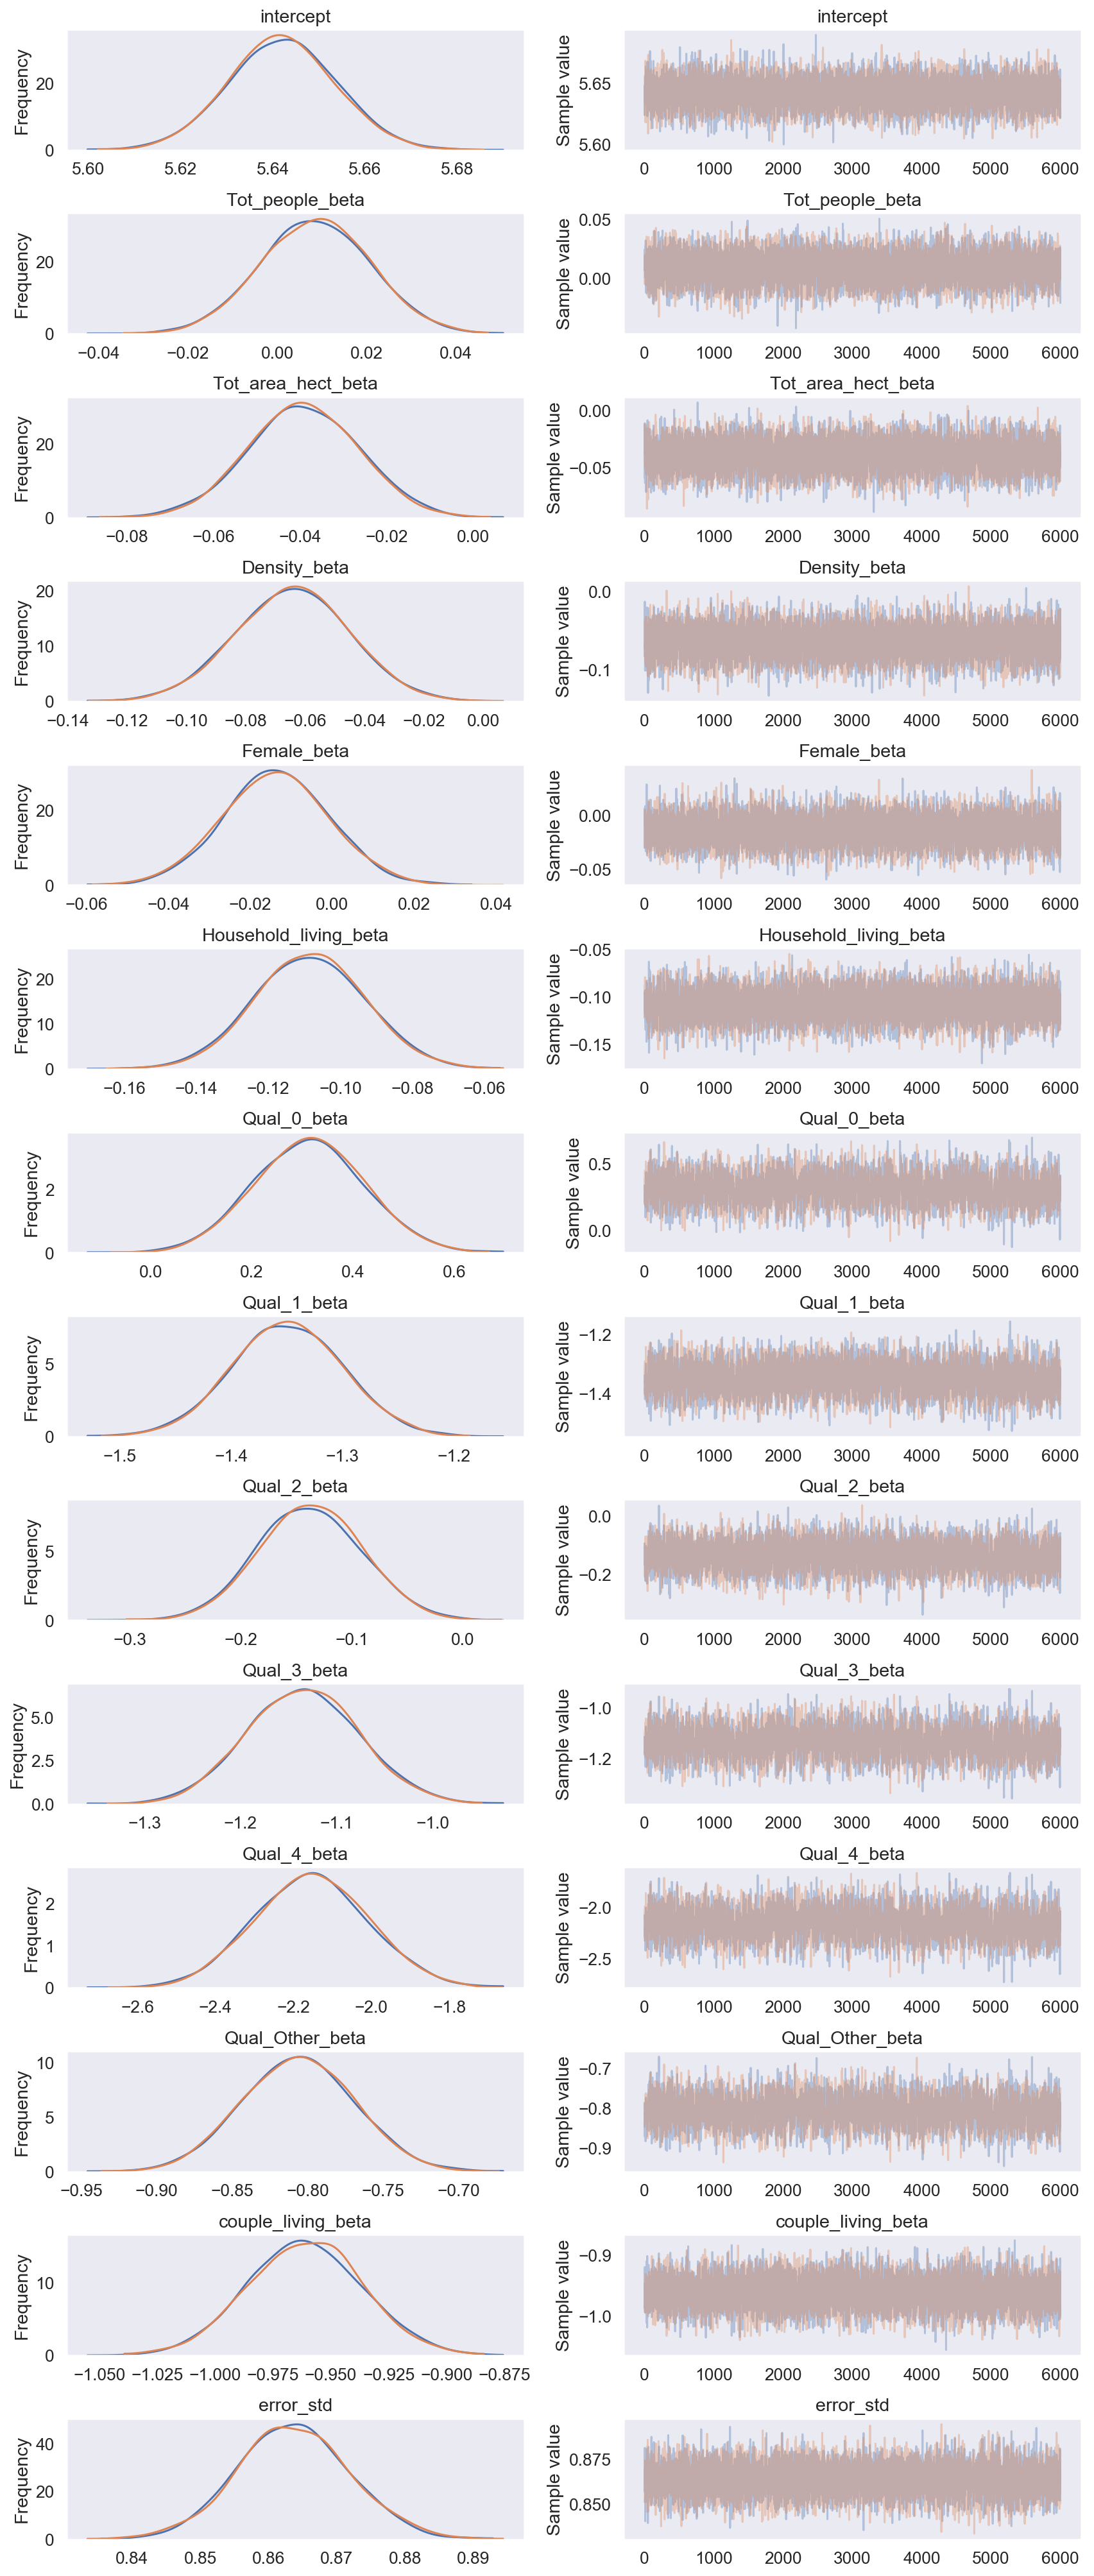

In [114]:
pm.traceplot(trace_laplace, combined=False)
plt.tight_layout()
#plt.savefig('images/Traceplots_laplace.png', dpi=200)
plt.show()

This forest plot below shows the most likely value of the parameter (the dot) as well as the 95% credible interval. The credible intervals are tiny for most of the parameters, but there is most uncertainty around the beta for Qual_4 and Qual_0. Importantly, we see similar parameter estimates to those of my lasso model. 

Because there is more than one chain in the trace, the potential scale reduction parameter (r-hat statistic) is shown on the right.  

This tells us how closely the values have converged, and values near one, as is the case here, suggest the model has converged to the true posterior.

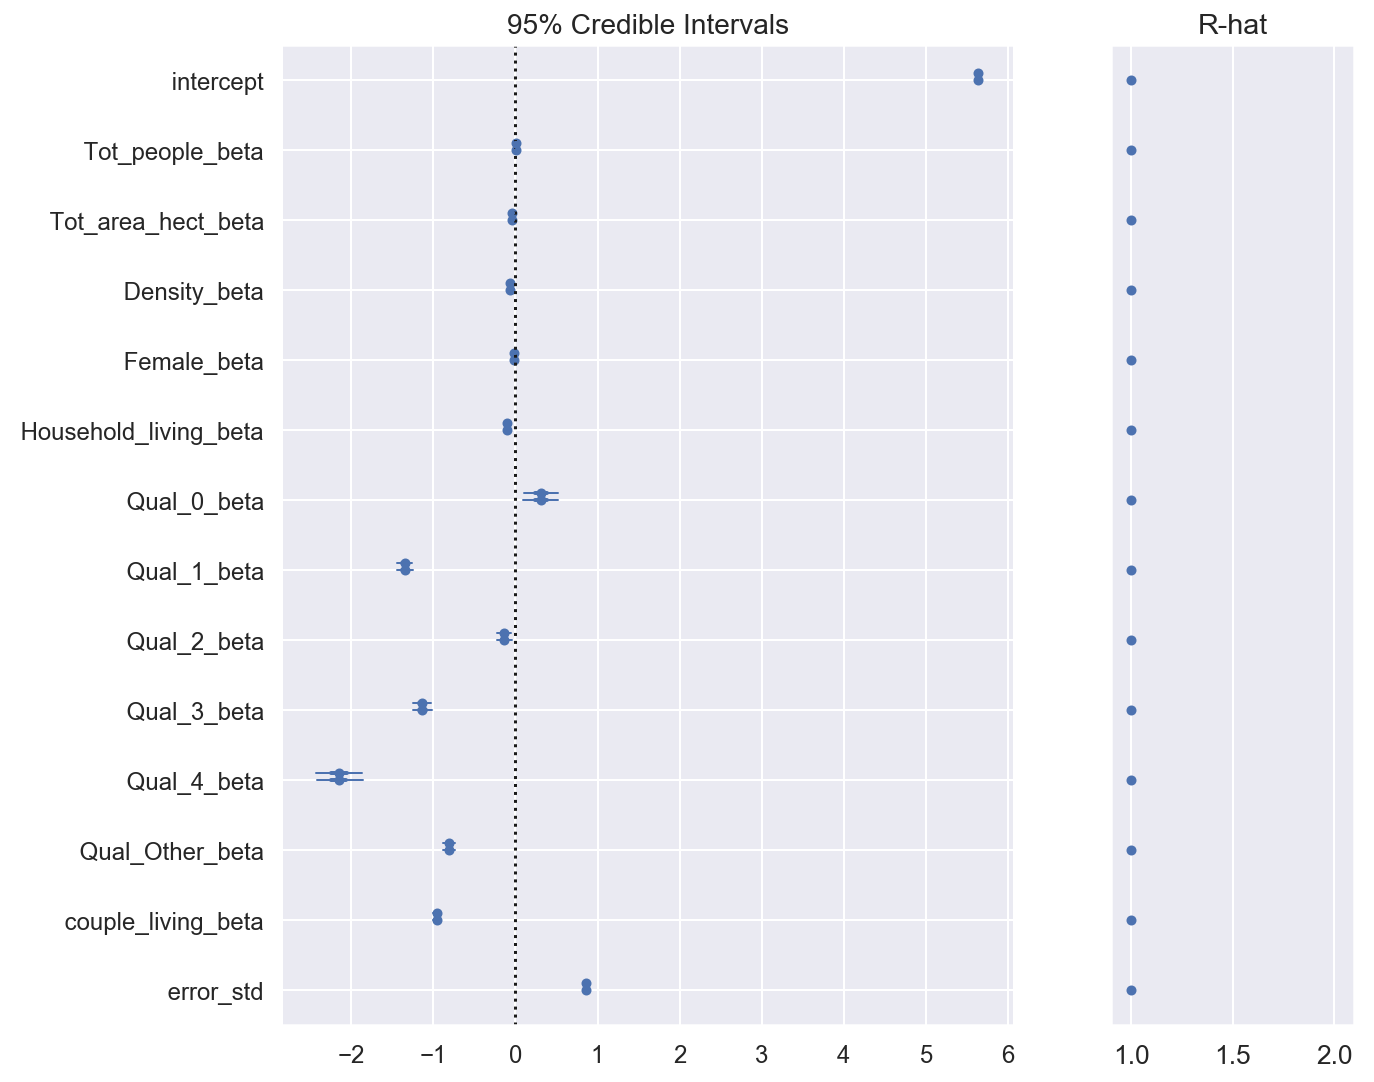

In [169]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(figsize=(12,8))
fig = pm.forestplot(trace_laplace)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(label='95% Credible Intervals', fontsize=14)

#plt.savefig('images/forest_plot_laplace.png', dpi=200, bbox_inches='tight', pad_inches=0.2)
plt.tight_layout()
plt.show()

In [159]:
#Here I set up a dataframe with all my summary results. 
bayes_results = pm.summary(trace_laplace)
bayes_results

mean        sd  mc_error   hpd_2.5  hpd_97.5  \
intercept              5.641849  0.011443  0.000108  5.618227  5.663340   
Tot_people_beta        0.008439  0.012067  0.000105 -0.015393  0.031819   
Tot_area_hect_beta    -0.039342  0.012614  0.000129 -0.063191 -0.013614   
Density_beta          -0.064671  0.018931  0.000189 -0.101757 -0.027611   
Female_beta           -0.013872  0.012792  0.000120 -0.038405  0.011579   
Household_living_beta -0.108555  0.015156  0.000157 -0.138567 -0.079386   
Qual_0_beta            0.312923  0.107437  0.002178  0.094834  0.513980   
Qual_1_beta           -1.350251  0.049032  0.000834 -1.447231 -1.254676   
Qual_2_beta           -0.137649  0.045926  0.000803 -0.226742 -0.047921   
Qual_3_beta           -1.135974  0.057792  0.001170 -1.249854 -1.023819   
Qual_4_beta           -2.154744  0.144103  0.002929 -2.427865 -1.868165   
Qual_Other_beta       -0.806746  0.036530  0.000715 -0.879414 -0.737649   
couple_living_beta    -0.961266  0.024463  0.000287 -1.009976 -0.914195   
error_std              0.863531  0.008115  0.000070  0.847805  0.879756   

                              n_eff      Rhat  
intercept              11326.423131  1.000101  
Tot_people_beta        11932.268836  0.999918  
Tot_area_hect_beta     11664.403604  1.000167  
Density_beta            9851.994090  0.999966  
Female_beta            11446.689389  1.000138  
Household_living_beta  10688.933288  0.999922  
Qual_0_beta             2488.595361  0.999967  
Qual_1_beta             3549.328293  0.999920  
Qual_2_beta             3477.776765  1.000012  
Qual_3_beta             2514.713444  0.999925  
Qual_4_beta             2495.800598  0.999960  
Qual_Other_beta         2693.753883  0.999924  
couple_living_beta      6010.089967  0.999928  
error_std              14732.308540  0.999929

In [116]:
#This is just setting up a dataframe that contains all the results from the trace. 
#It will contain 12000 rows, corresponding to the 6000 samples x 2 chains set up in my model. 
data = pm.trace_to_dataframe(trace_laplace)
print(data.shape)
data.head(2)

(12000, 14)


intercept  Tot_people_beta  Tot_area_hect_beta  Density_beta  Female_beta  \
0   5.647287         0.009947           -0.037216     -0.069693    -0.030534   
1   5.623931         0.006524           -0.050401     -0.082996     0.006278   

   Household_living_beta  Qual_0_beta  Qual_1_beta  Qual_2_beta  Qual_3_beta  \
0              -0.099772     0.337316    -1.340115    -0.094146    -1.115948   
1              -0.122270     0.275489    -1.341359    -0.160022    -1.144915   

   Qual_4_beta  Qual_Other_beta  couple_living_beta  error_std  
0    -2.074492        -0.787799           -0.954324   0.857992  
1    -2.157719        -0.802311           -0.987511   0.857086

<a id="scoring"></a>
##### Scoring

To score the model, I sample y-values from the posterior and get the mean of these points to compare to the 5760 actual y values contained in my df_bayes dataframe. 

In [117]:
preds = pm.sample_posterior_predictive(trace_laplace, model=reg_laplace)
print(preds['y_mean'].shape)

100%|██████████| 12000/12000 [00:16<00:00, 729.44it/s]


(12000, 5760)


In [118]:
pm.r2_score(df_bayes.y, preds['y_mean'].mean(axis=0), round_to=4).r2_mean

0.8302

In [145]:
#These are the 95% credible intervals, I have two sets because of the two chains. I assume I average these? 
pm.hpd(trace_laplace)

{0: {'error_std_interval__': array([-2.39059079, -2.35090962]),
  'intercept': array([5.61901101, 5.66442346]),
  'Tot_people_beta': array([-0.01491896,  0.03195458]),
  'Tot_area_hect_beta': array([-0.06612774, -0.01550377]),
  'Density_beta': array([-0.10360959, -0.02882501]),
  'Female_beta': array([-0.03806568,  0.01142618]),
  'Household_living_beta': array([-0.13911562, -0.07955932]),
  'Qual_0_beta': array([0.09677767, 0.51928549]),
  'Qual_1_beta': array([-1.44268891, -1.24833973]),
  'Qual_2_beta': array([-0.22439346, -0.04312831]),
  'Qual_3_beta': array([-1.25073719, -1.02210422]),
  'Qual_4_beta': array([-2.41968587, -1.85450876]),
  'Qual_Other_beta': array([-0.87945272, -0.73599394]),
  'couple_living_beta': array([-1.0099758 , -0.91420241]),
  'error_std': array([0.84809123, 0.87906504])},
 1: {'error_std_interval__': array([-2.39172441, -2.34961954]),
  'intercept': array([5.61867355, 5.66326026]),
  'Tot_people_beta': array([-0.01678194,  0.03045965]),
  'Tot_area_hect

In [155]:
(pm.hpd(trace_laplace)[0]['Tot_people_beta'] + pm.hpd(trace_laplace)[1]['Tot_people_beta'])/2

array([-0.01585045,  0.03120712])

<a id="comparisons"></a>
#### Comparing results from Lasso and Bayesian Models

In [ ]:
#making sure the features have the same name so I can merge on these
lasso_coefs.Feature = lasso_coefs.Feature.map(lambda x: x.strip('%'))
lasso_coefs.drop(columns='Abs_coef', inplace=True)
lasso_coefs.columns=['Feature', 'Lasso_Coef']

In [125]:
#filtering out the intercept and standard error
bayes_mean = bayes_results[['mean']][1:-1].reset_index()
bayes_mean.columns = ['Feature', 'Bayes_Mean']
bayes_mean.Feature = bayes_mean.Feature.map(lambda x: x.replace('_beta', ''))
bayes_mean

Feature  Bayes_Mean
0         Tot_people    0.008439
1      Tot_area_hect   -0.039342
2            Density   -0.064671
3             Female   -0.013872
4   Household_living   -0.108555
5             Qual_0    0.312923
6             Qual_1   -1.350251
7             Qual_2   -0.137649
8             Qual_3   -1.135974
9             Qual_4   -2.154744
10        Qual_Other   -0.806746
11     couple_living   -0.961266

In [126]:
compare_coefs = pd.merge(lasso_coefs, bayes_mean, on='Feature')
compare_coefs.drop(columns='Abs_coef', inplace=True)
compare_coefs.set_index('Feature', drop=True, inplace=True)
compare_coefs.index.name=None

In [127]:
compare_coefs

Coef  Bayes_Mean
Qual_4        -1.722124   -2.154744
Qual_1        -1.221740   -1.350251
Qual_3        -0.962104   -1.135974
couple_living -0.926338   -0.961266
Qual_Other    -0.703358   -0.806746
Qual_0         0.629280    0.312923
Density       -0.058202   -0.064671
Tot_area_hect -0.040361   -0.039342
Qual_2        -0.026795   -0.137649
Tot_people     0.002537    0.008439

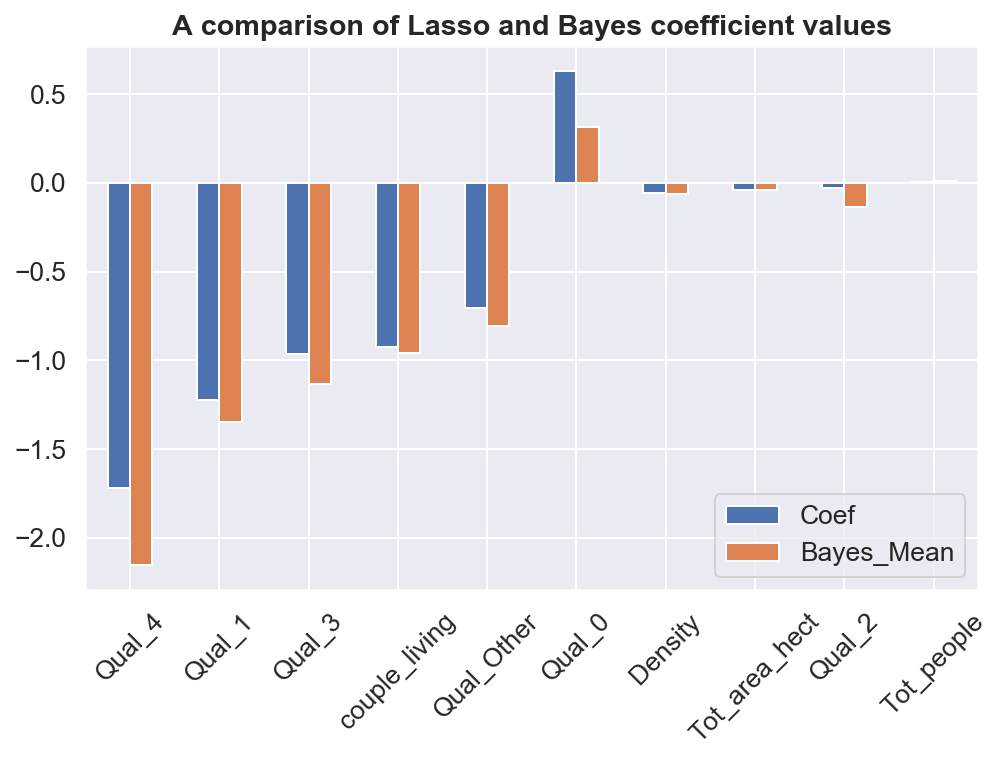

In [129]:
sns.set_style('darkgrid')

fig, ax = plt.subplots(figsize=(8,5))
compare_coefs.plot(kind='bar', ax=ax)
ax.legend(loc=(4))
plt.xticks(rotation=45)
plt.title('A comparison of Lasso and Bayes coefficient values', fontweight='bold')
#plt.savefig('images/lasso_vs_bayes.png', dpi=200, bbox_inches='tight', pad_inches=0.2)

plt.show()

<b>Notes: </b>Although this is not the best way to compare my two models, it does show their similarity. The most interesting comparison would be between the mode of the beta posteriors and the lasso coefficients, but the mode is surprisingly difficult to obtain from the trace!

What this does tell us is that the two models have come to the same conclusion about what features are positively and negatively impacting our target variable of poor health, and with what weighting. Further conclusions can be found in the <a href="./summary_and_conclusions">summary and conclusions report<a/>.